In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Unzip Classical music

In [ ]:
!unzip "/content/drive/MyDrive/Classical Music" -d "/content"

Archive:  /content/drive/MyDrive/Classical Music.zip
   creating: /content/Classical Music/Train/
  inflating: /content/Classical Music/Train/_beet7_1.mid  
  inflating: /content/Classical Music/Train/_beet7_2.mid  
  inflating: /content/Classical Music/Train/_beet7_3.mid  
  inflating: /content/Classical Music/Train/01pasali.mid  
  inflating: /content/Classical Music/Train/01promes.mid  
  inflating: /content/Classical Music/Train/02holnit.mid  
  inflating: /content/Classical Music/Train/02regven.mid  
  inflating: /content/Classical Music/Train/03manger.mid  
  inflating: /content/Classical Music/Train/04adeste.mid  
  inflating: /content/Classical Music/Train/04gita.mid  
  inflating: /content/Classical Music/Train/05littre.mid  
  inflating: /content/Classical Music/Train/06chimes.mid  
  inflating: /content/Classical Music/Train/06dealpi.mid  
  inflating: /content/Classical Music/Train/07slumsg.mid  
  inflating: /content/Classical Music/Train/08pesca.mid  
  inflating: /conten

# Unzip generation input music

In [ ]:
!unzip "/content/drive/MyDrive/Generated Music" -d "/content"

Archive:  /content/drive/MyDrive/Generated Music.zip
   creating: /content/Generated Music/Input/
  inflating: /content/Generated Music/Input/001.midi  
  inflating: /content/Generated Music/Input/004.midi  
  inflating: /content/Generated Music/Input/009.midi  
  inflating: /content/Generated Music/Input/014.midi  
  inflating: /content/Generated Music/Input/015.midi  
  inflating: /content/Generated Music/Input/025.midi  
  inflating: /content/Generated Music/Input/026.midi  
  inflating: /content/Generated Music/Input/029.midi  
  inflating: /content/Generated Music/Input/032.midi  


# install

In [ ]:
!pip install torch

In [ ]:
!pip install miditok

     |████████████████████████████████| 60 kB 6.4 MB/s 
     |████████████████████████████████| 51 kB 8.8 MB/s 


In [ ]:
!pip install miditoolkit
from miditok import REMI, get_midi_programs
from miditoolkit import MidiFile
from pathlib import Path

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from torch import optim
import math


# create datasets

In [ ]:
# define a function to pad seqeunce to a fixed length
def padREMI(remi_list,max_length=7500):
  padded_Remi = np.zeros((len(remi_list),max_length),dtype=int) 
  for idx, remi in enumerate(remi_list):
    remi_length = len(remi)
    if remi_length <= max_length:
      # if the length is too small, add 0's in the beginning of the review vector
      #  to make the size max_length
      zeros = list(np.zeros(max_length-remi_length))
      new_sequence = zeros + remi
    else:
      new_sequence = remi[:max_length]
    padded_Remi[idx,:] = np.array(new_sequence)
  return padded_Remi



In [ ]:
# define a function extract REMI representations for the right hand
pitch_range = range(21, 109)
beat_res = {(0, 4): 8, (4, 12): 4}
nb_velocities = 32
tokenizer = REMI(pitch_range,beat_res,nb_velocities)
num_vocab = len(tokenizer.vocab) # number of vocabularies
print(num_vocab)

218


## get remi for all midi files

In [ ]:


paths_train = list(Path("Classical Music/Train").glob("**/*.mid"))
#paths_train2 = list(Path("Pop-music2/Train").glob("**/*.midi"))
print("training samples 1: ",len(paths_train))
#print("training samples 2: ",len(paths_train2))

paths_val = list(Path("Classical Music/Val").glob("**/*.mid"))
#paths_val2 = list(Path("Pop-music2/Val").glob("**/*.midi"))
print("validation samples 1: ", len(paths_val))
#print("validation samples 2: ", len(paths_val2))

# define a function to validate if the MIDI file is valid
def midi_valid(midi):
  if any(ts.numerator != 4 or ts.denominator != 4 for ts in midi.time_signature_changes):
      return False  # time signature different from 4/4
  if midi.max_tick < 10 * midi.ticks_per_beat:
      return False  # this MIDI is too short
  return True

# tokenize training dataset
tokenizer.tokenize_midi_dataset(paths_train,"Classical Music/train")
#tokenizer.tokenize_midi_dataset(paths_train2,"Pop-music-REMI2/train2")
#tokenizer.tokenize_midi_dataset(paths_val,"Pop-music-REMI2/val")
#tokenizer.tokenize_midi_dataset(paths_val2,"Pop-music-REMI2/val2")



training samples 1:  1356
validation samples 1:  156
1355 / 1356 [==============================] 99.9% ...Converting MIDIs to tokens: Classical Music/Train/kindersz.mid

In [ ]:
# tokenize validation dataset
tokenizer.tokenize_midi_dataset(paths_val,"Classical Music/val",midi_valid)

155 / 156 [==============================] 99.4% ...Converting MIDIs to tokens: Classical Music/Val/han4281.mid

In [ ]:
# read jason files and form a list holding all the objects
import json
from tqdm.auto import tqdm
folder = "Pop-music-REMI2/train2"
filenames = os.listdir(folder)
tokens_train2 = []
progress = tqdm(range(len(filenames)))
print("total files: ", len(filenames))
for i in np.arange(len(filenames)):
  if filenames[i] == "config.txt":
    progress.update(1)
    continue
  else:
    f = open(os.path.join(folder,filenames[i]))
    a = json.load(f)
    tokens = a[0][0]
    tokens_train2.append(tokens)
    progress.update(1)

print(len(tokens_train2))

# tokens_train1, tokens_train2

  0%|          | 0/1605 [00:00<?, ?it/s]

total files:  1605
1604


In [ ]:
tokens_train1.extend(tokens_train2)
print(len(tokens_train1))

2322


In [ ]:
print(tokens_train1[0])

[1, 216, 35, 101, 145, 39, 100, 123, 42, 101, 146, 47, 103, 144, 51, 104, 131, 217, 23, 102, 122, 58, 107, 122, 1, 186, 58, 108, 127, 192, 58, 103, 140, 194, 51, 104, 138, 56, 104, 138, 210, 38, 102, 153, 41, 101, 153, 44, 101, 128, 46, 103, 126, 50, 104, 128, 214, 58, 108, 125, 217, 46, 102, 130, 50, 102, 130, 1, 186, 58, 108, 129, 194, 50, 103, 129, 58, 107, 138, 196, 56, 104, 127, 202, 50, 104, 130, 56, 107, 130, 210, 39, 100, 153, 42, 101, 153, 46, 98, 125, 51, 104, 153, 214, 58, 107, 125, 1, 186, 58, 108, 129, 194, 58, 104, 139, 196, 56, 102, 136, 210, 35, 103, 153, 39, 101, 123, 44, 101, 153, 47, 104, 122, 51, 105, 138, 214, 58, 107, 125, 1, 186, 58, 108, 135, 194, 61, 106, 138, 198, 59, 108, 134, 200, 58, 108, 132, 202, 56, 108, 130, 204, 54, 108, 128, 206, 51, 105, 125, 209, 47, 103, 123, 210, 35, 103, 153, 39, 104, 122, 42, 102, 153, 51, 107, 153, 211, 58, 107, 140, 214, 56, 107, 139, 1, 198, 58, 104, 125, 200, 56, 103, 125, 202, 58, 108, 125, 204, 56, 107, 124, 206, 58, 108, 

In [ ]:
folder = "Pop-music-REMI2/val2"
filenames = os.listdir(folder)
tokens_val2 = []
progress = tqdm(range(len(filenames)))
print("total files: ", len(filenames))
for i in np.arange(len(filenames)):
  if filenames[i] == "config.txt":
    progress.update(1)
    continue
  else:
    progress.update(1)
    f = open(os.path.join(folder,filenames[i]))
    a = json.load(f)
    tokens = a[0][0]
    tokens_val2.append(tokens)
    

print(len(tokens_val2))


# tokens_val, tokens_val2

  0%|          | 0/145 [00:00<?, ?it/s]

total files:  145
144


In [ ]:
tokens_val.extend(tokens_val2)
print(len(tokens_val))

201


In [ ]:
# make sure they are the same
tokens = tokens_train1[0]
len(tokens)

5054

In [ ]:
%cp -av "/content/Classical Music/val" "/content/drive/MyDrive"

'/content/Classical Music/val' -> '/content/drive/MyDrive/val'
'/content/Classical Music/val/sydvs804.json' -> '/content/drive/MyDrive/val/sydvs804.json'
'/content/Classical Music/val/chpn_op7_1.json' -> '/content/drive/MyDrive/val/chpn_op7_1.json'
'/content/Classical Music/val/beet_3_2.json' -> '/content/drive/MyDrive/val/beet_3_2.json'
'/content/Classical Music/val/sonata__6.json' -> '/content/drive/MyDrive/val/sonata__6.json'
'/content/Classical Music/val/aj_lis13.json' -> '/content/drive/MyDrive/val/aj_lis13.json'
'/content/Classical Music/val/gfhouv.json' -> '/content/drive/MyDrive/val/gfhouv.json'
'/content/Classical Music/val/chopol10.json' -> '/content/drive/MyDrive/val/chopol10.json'
'/content/Classical Music/val/mendel.json' -> '/content/drive/MyDrive/val/mendel.json'
'/content/Classical Music/val/haydn.json' -> '/content/drive/MyDrive/val/haydn.json'
'/content/Classical Music/val/allegro_.json' -> '/content/drive/MyDrive/val/allegro_.json'
'/content/Classical Music/val/sysmb

## pad them

In [ ]:
# pad sequence
padded_train = padREMI(tokens_train1)


In [ ]:
pop_padded_train_tokens_7500 = np.array(padded_train)
print("padded train data shape: ", pop_padded_train_tokens_7500.shape)

padded train data shape:  (2322, 7500)


In [ ]:
np.save("pop_padded_train_tokens_7500.npy",pop_padded_train_tokens_7500)
!cp pop_padded_train_tokens_7500.npy /content/drive/MyDrive/

In [ ]:
pop_padded_val_tokens_7500 = padREMI(tokens_val)
pop_padded_val_tokens_7500 = np.array(pop_padded_val_tokens_7500)
print("padded val data shape: ", pop_padded_val_tokens_7500.shape)

padded val data shape:  (201, 7500)


In [ ]:
np.save("pop_padded_val_tokens_7500.npy",pop_padded_val_tokens_7500)
!cp pop_padded_val_tokens_7500.npy /content/drive/MyDrive/

# Customized Dataset

In [ ]:

class customDataset(data.Dataset):
  def __init__(self,npy_path):
    self.data = np.load(npy_path) # shape (sample,sequence_length)
    print("Data Shape: ", self.data.shape)
  
  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self,index):
    sequence = self.data[index]
    input_seq = sequence[:-1]
    output_seq = sequence[1:]
    return (input_seq, output_seq)


# Dataloader

In [ ]:
!cp /content/drive/MyDrive/customized_val_512.npy /content/padded_val_tokens.npy 

In [ ]:
!cp /content/drive/MyDrive/customized_training_512.npy /content/padded_train_tokens.npy 

In [ ]:


train_dataset = customDataset("/content/padded_train_tokens.npy")
train_dataloader = data.DataLoader(train_dataset,batch_size=4,shuffle=True)



Data Shape:  (24613, 512)


In [ ]:

val_dataset = customDataset("/content/padded_val_tokens.npy")


set1 = list(range(0,len(val_dataset),2))
set2 = list(range(1,len(val_dataset),2))
#set3 = list(range(2,len(val_dataset),4))
#set4 = list(range(3,len(val_dataset),4))

val1 = data.Subset(val_dataset,set1)
val2 = data.Subset(val_dataset,set2)
#val3 = data.Subset(val_dataset,set3)
#val4 = data.Subset(val_dataset,set4)

size=4

val_dataloader1 = data.DataLoader(val1,batch_size=size,shuffle=True)
val_dataloader2 = data.DataLoader(val2,batch_size=size,shuffle=True)
#val_dataloader3 = data.DataLoader(val3,batch_size=size,shuffle=True)
#val_dataloader4 = data.DataLoader(val4,batch_size=size,shuffle=True)

val_dataloader = [val_dataloader1,
               val_dataloader2]



Data Shape:  (2272, 512)


In [ ]:
# check
X_val = next(iter(val_dataloader[0]))
print(X_val[0].shape) # input seq
print(X_val[1].shape) # output seq

torch.Size([4, 511])
torch.Size([4, 511])


In [ ]:
# check
X_train = next(iter(train_dataloader))
print(X_train[0].shape) # input seq
print(X_train[1].shape) # output seq

torch.Size([4, 511])
torch.Size([4, 511])


# Training and Validation Routine

In [ ]:
def evaluate(model,val_loader,device,loss_fn):
    model.eval()
    val_loss = 0.0
    steps = 0
    
    for batch in val_loader:
        steps += 1
        input_seq, output_seq = batch
        input_seq, output_seq = input_seq.to(device), output_seq.to(device)
        # try to fix error :"addmm_cuda" not implemented for 'Long'
        input_seq = input_seq.long()
        
        
        final,_ = model(input_seq)
        # try to fix:"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
        #final, output_seq = final.double(),output_seq.double()
        output_seq = output_seq.long()
        loss = loss_fun(final.transpose(1,2), output_seq) 
        val_loss += loss.item()
    
    print("The mean validation loss is %.6f" % (val_loss/steps))
    print()
    return val_loss/steps

In [ ]:
def train(model,trainloader,valloader,ep,print_freq,loss_fun,
          optimizer,device,run,grad_clip=1.0,mname="LSTM",scheduler=None):
    val_loss_best = float("inf")
    
    # total number of training steps
    num_steps = ep * (len(trainloader))
    progress_bar = tqdm(range(num_steps))
    
    # calculate how often print the result
    #  if num_step = 12, and print_freq = 3, then print every 4 steps
    print_every = math.floor(num_steps/print_freq)
    
    # initialize
    steps = 0
    #model.to(device) ## error when run this twice
    model.train()
    train_losses = []
    val_losses = []
    which_val = 0
    
    for e in range(ep):
        current_loss = 0
        for batch in trainloader:
            input_s, output_s = batch
            steps += 1
            input_seq, output_seq = input_s.to(device), output_s.to(device)
            optimizer.zero_grad()
            input_seq = input_seq.long() # fix error 1
            final,_ = model(input_seq)
            output_seq = output_seq.long() # fix error 1
            loss = loss_fun(final.transpose(1,2), output_seq) 
            current_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
            optimizer.step()
            
            # update progress bar
            progress_bar.update(1)
            
            # print if reach the threshold we want
            if steps % print_every == 0:
                # training loss: divided by the number of steps taken during training
                #  from last print to current print
                print('EPOCHS : {}/{}'.format(e+1,ep),
                          'Loss : {:.6f}'.format(current_loss/print_every))
                train_losses.append(current_loss/print_every)

                current_loss = 0
                which_val = random.randint(0,1)
                # val loss: divided by the number of steps taken when validate
                val_loss = evaluate(model,valloader[which_val],device,loss_fun)
                val_losses.append(val_loss)
                
                # add call back
                if val_loss < val_loss_best:
                    val_loss_best = val_loss
                    torch.save(model.state_dict(),
                     "/content/drive/MyDrive/WeightsREMI/"+mname+"-run-{}-val_loss-BEST.pth".format(run))
                else:
                  torch.save(model.state_dict(),
                     "/content/drive/MyDrive/WeightsREMI/"+mname+"-run-{}-val_loss-LAST.pth".format(run))
                
            model.train()
        if scheduler and (e+(ep*(run-1)) <= 10):
          scheduler.step()

    return train_losses, val_losses

In [ ]:
# check performance
import matplotlib.pyplot as plt

def plot_loss(train_loss,val_loss,run,ylimit=None,modelname="PopComplexLSTM_REMI2"):
  plt.figure(figsize=(12,8))
  epochs = np.arange(1/5, (len(train_loss) + 1)/5,1/5)
  plt.plot(epochs, train_loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  if ylimit:
    plt.ylim(ylimit)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f"The Traininga and Validation Loss for {modelname} - Run - {str(run)} - {len(train_loss)//5} Epochs")
  plt.legend()
  plt.savefig("/content/drive/MyDrive/Plots_REMI/"+modelname+f"run{str(run)}.jpg")
  plt.show() 

# Model - ComplexLSTM

In [ ]:
class ComplexLSTM(nn.Module):
    def __init__(self, num_embeddings = 218, embed_size = 512, hidden_size = 1024, 
                  num_class = 218, layers = 2):
        super(ComplexLSTM, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        self.layers = layers
        self.embedding_layer = nn.Embedding(num_embeddings,embed_size,padding_idx=0)
        self.layernorm_encoder = nn.LayerNorm(embed_size)
        self.layernorm_lstm = nn.LayerNorm(hidden_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,layers)
        self.final = nn.Linear(hidden_size,num_class)
        self.final = nn.Linear(hidden_size,512)
        self.final2 = nn.Linear(512,num_class)
        self.relu = nn.ReLU()
        
    def forward(self,sequences,hidden=None):
        # seq shape (batch,seq_len,88)
        # embedding layer: ignored padding_idx which is 0
        notes_embedded = self.embedding_layer(sequences) # shape (batch,seq_len,embed_size)
        

        notes_lnormed = self.layernorm_encoder(notes_embedded)
        notes_lnormed = nn.Dropout(0.3)(notes_lnormed)

        
        # output shape (batch,seq_len,hidden_size)
        output, hidden = self.lstm(notes_lnormed,hidden)
        
        #output_lnormed = self.layernorm_lstm(output.permute(1,2,0).contiguous())
        output_lnormed = self.layernorm_lstm(output)
        output_lnormed = nn.Dropout(0.3)(output_lnormed)
        

        
        # only take the final 1000
        #output_lnormed = output_lnormed[:,-1000:,:] 
        
        # final shape (batch,200,num_class)
        #final = self.final(output_lnormed.permute(2,0,1))
        final = self.final(output_lnormed) # final (batch,200,hidden_size) --> 
                                            #                 (batch,200,88)
        
        final = self.relu(final)
        final = nn.Dropout(0.5)(final)
        final = self.final2(final)
        
        return final, hidden

In [ ]:
PopComplexLSTM_REMI = ComplexLSTM().cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(PopComplexLSTM_REMI.parameters(),lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.5,verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


## PopComplexLSTM_REMI

In [ ]:
train_loss, val_loss = train(PopComplexLSTM_REMI,train_dataloader,val_dataloader,20,200,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="PopComplexLSTM_REMI",scheduler=scheduler)
# 18 hours vs 5 hours: 2048 vs 1024
# 5 hours vs 2 hours: LSTM vs transformer - 2000/ 2-2
# 13 mins vs 50 mins: LSTM vs transformer - 512/ 12-8

  0%|          | 0/123080 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 3.621479
The mean validation loss is 3.350563

EPOCHS : 1/20 Loss : 3.356021
The mean validation loss is 3.303074

EPOCHS : 1/20 Loss : 3.322901
The mean validation loss is 3.285546

EPOCHS : 1/20 Loss : 3.307416
The mean validation loss is 3.286930

EPOCHS : 1/20 Loss : 3.295603
The mean validation loss is 3.271540

EPOCHS : 1/20 Loss : 3.293040
The mean validation loss is 3.266193

EPOCHS : 1/20 Loss : 3.293309
The mean validation loss is 3.272759

EPOCHS : 1/20 Loss : 3.289114
The mean validation loss is 3.256412

EPOCHS : 1/20 Loss : 3.282643
The mean validation loss is 3.256123

EPOCHS : 1/20 Loss : 3.286995
The mean validation loss is 3.253265

Adjusting learning rate of group 0 to 5.0000e-05.
EPOCHS : 2/20 Loss : 3.256831
The mean validation loss is 3.252722

EPOCHS : 2/20 Loss : 3.279272
The mean validation loss is 3.252935

EPOCHS : 2/20 Loss : 3.277426
The mean validation loss is 3.257162

EPOCHS : 2/20 Loss : 3.285528
The mean validation loss is 3.254869

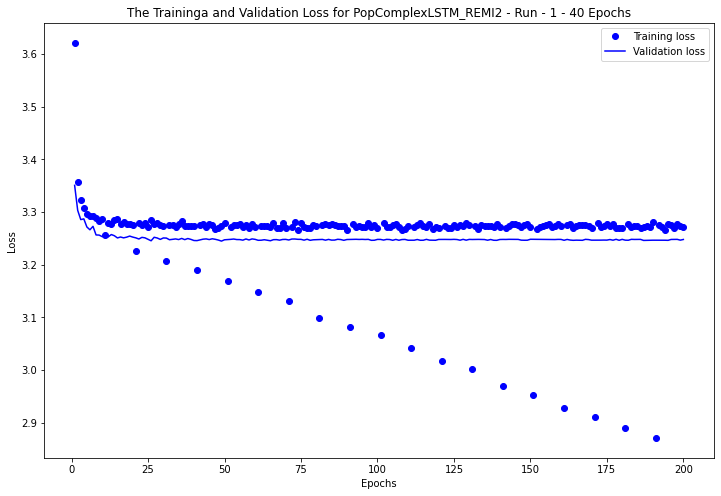

In [ ]:
np.save("PopComplexLSTM_REMI_run1_trainloss.npy",np.array(train_loss))
np.save("PopComplexLSTM_REMI_run1_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI_run1_trainloss.npy /content/drive/MyDrive/losses
!cp PopComplexLSTM_REMI_run1_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,1)

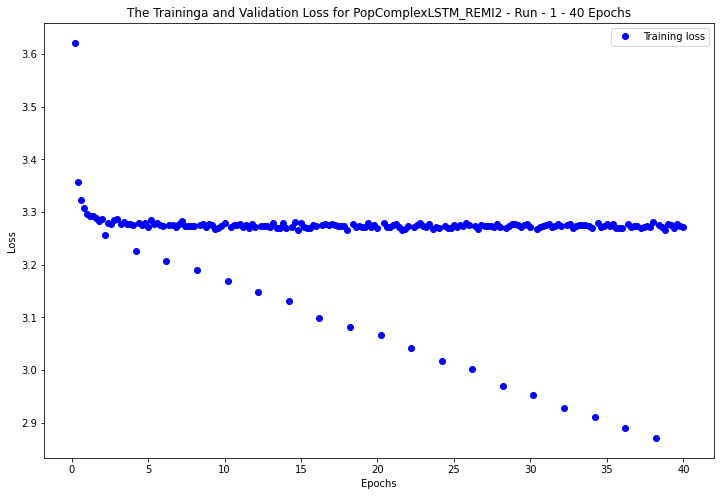

In [ ]:
plot_loss(train_loss,val_loss,1)

In [ ]:
train_loss, val_loss = train(PopComplexLSTM_REMI,train_dataloader,val_dataloader,10,50,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="PopComplexLSTM_REMI",scheduler=scheduler)

## PopComplexLSTM_REMI - length 5000

### 20 epochs

In [ ]:
train_loss, val_loss = train(PopComplexLSTM_REMI,train_dataloader,val_dataloader,20,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="PopComplexLSTM_REMI")

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 5.183709
The mean validation loss is 3.870911

EPOCHS : 1/20 Loss : 4.788650
The mean validation loss is 2.864215

EPOCHS : 2/20 Loss : 4.410147
The mean validation loss is 2.492487

EPOCHS : 2/20 Loss : 4.348071
The mean validation loss is 2.251989

EPOCHS : 3/20 Loss : 4.020100
The mean validation loss is 2.077865

EPOCHS : 3/20 Loss : 3.981063
The mean validation loss is 1.922231

EPOCHS : 4/20 Loss : 3.589805
The mean validation loss is 1.809697

EPOCHS : 4/20 Loss : 3.719403
The mean validation loss is 1.753466

EPOCHS : 5/20 Loss : 3.269821
The mean validation loss is 1.707434

EPOCHS : 5/20 Loss : 3.487507
The mean validation loss is 1.638120

EPOCHS : 6/20 Loss : 3.034307
The mean validation loss is 1.597962

EPOCHS : 6/20 Loss : 3.352824
The mean validation loss is 1.581635

EPOCHS : 7/20 Loss : 2.897933
The mean validation loss is 1.567096

EPOCHS : 7/20 Loss : 3.259102
The mean validation loss is 1.549227

EPOCHS : 8/20 Loss : 2.795547
The mean validatio

In [ ]:
np.save("PopComplexLSTM_REMI_run1_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI_run1_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI_run1_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI_run1_valloss.npy /content/drive/MyDrive/losses

In [ ]:
def loss_per_epoch(loss):
  ave_loss = []
  n = len(loss)
  i = 0
  while i < n:
    if i+1 == n:
      ave_loss.append(loss[i])
      break
    ave = (loss[i] + loss[i+1]) / 2
    ave_loss.append(ave)
    i += 2
  return ave_loss

In [ ]:
train_loss_ave = loss_per_epoch(train_loss)
val_loss_ave = loss_per_epoch(val_loss)
np.save("PopComplexLSTM_REMI_run1_trainloss.npy",np.array(train_loss_ave))
!cp PopComplexLSTM_REMI_run1_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI_run1_valloss.npy",np.array(val_loss_ave))
!cp PopComplexLSTM_REMI_run1_valloss.npy /content/drive/MyDrive/losses

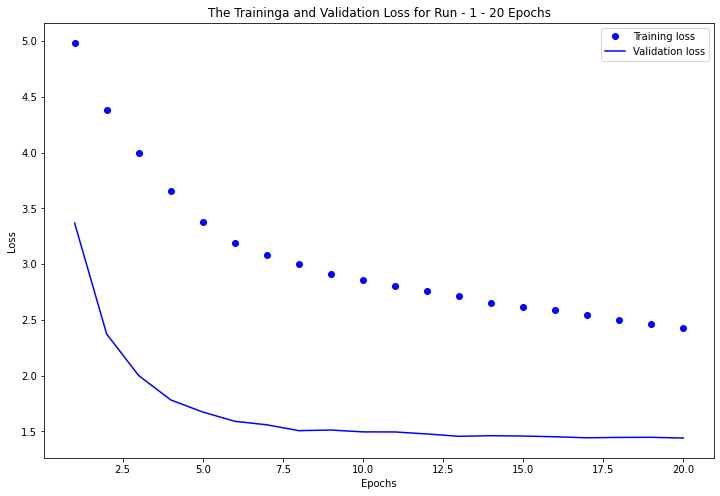

In [ ]:
plot_loss(train_loss_ave,val_loss_ave,1)

### 20 epochs

In [ ]:
optimizer = optim.AdamW(PopComplexLSTM_REMI.parameters(),lr=1e-6)
train_loss, val_loss = train(PopComplexLSTM_REMI,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="PopComplexLSTM_REMI")


  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 3.013479
The mean validation loss is 1.431395

EPOCHS : 2/20 Loss : 3.011280
The mean validation loss is 1.423780

EPOCHS : 3/20 Loss : 3.010087
The mean validation loss is 1.433323

EPOCHS : 4/20 Loss : 3.007904
The mean validation loss is 1.442191

EPOCHS : 5/20 Loss : 3.005984
The mean validation loss is 1.428792

EPOCHS : 6/20 Loss : 3.004191
The mean validation loss is 1.420882

EPOCHS : 7/20 Loss : 3.002360
The mean validation loss is 1.422756

EPOCHS : 8/20 Loss : 3.000796
The mean validation loss is 1.423511

EPOCHS : 9/20 Loss : 2.998666
The mean validation loss is 1.438271

EPOCHS : 10/20 Loss : 2.997211
The mean validation loss is 1.438497

EPOCHS : 11/20 Loss : 2.996099
The mean validation loss is 1.442603

EPOCHS : 12/20 Loss : 2.993238
The mean validation loss is 1.421125

EPOCHS : 13/20 Loss : 2.992294
The mean validation loss is 1.435460

EPOCHS : 14/20 Loss : 2.991366
The mean validation loss is 1.416513

EPOCHS : 15/20 Loss : 2.988835
The mean val

In [ ]:
np.save("PopComplexLSTM_REMI_run2_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI_run2_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI_run2_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI_run2_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,2,[1,4])

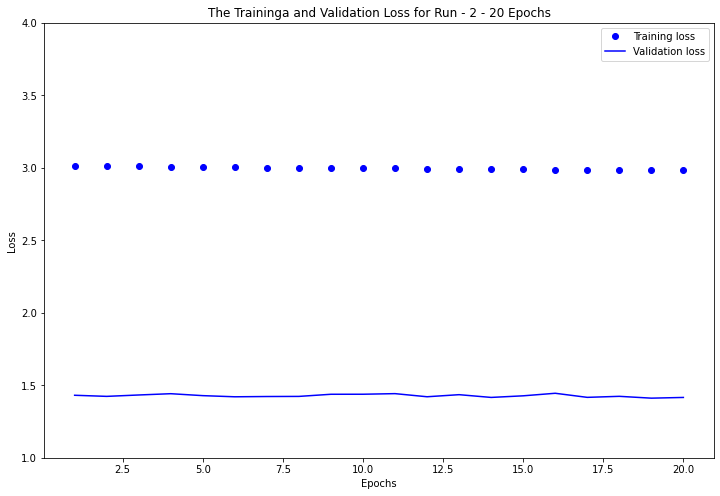

In [ ]:
plot_loss(train_loss,val_loss,2,[1,4])

### 20 epochs

In [ ]:

train_loss, val_loss = train(PopComplexLSTM_REMI,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="PopComplexLSTM_REMI")

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 2.980922
The mean validation loss is 1.440516

EPOCHS : 2/20 Loss : 2.979195
The mean validation loss is 1.410386

EPOCHS : 3/20 Loss : 2.979139
The mean validation loss is 1.427028

EPOCHS : 4/20 Loss : 2.978074
The mean validation loss is 1.417501

EPOCHS : 5/20 Loss : 2.975790
The mean validation loss is 1.413553

EPOCHS : 6/20 Loss : 2.974464
The mean validation loss is 1.415088

EPOCHS : 7/20 Loss : 2.973720
The mean validation loss is 1.417999

EPOCHS : 8/20 Loss : 2.972536
The mean validation loss is 1.416324

EPOCHS : 9/20 Loss : 2.970524
The mean validation loss is 1.450759

EPOCHS : 10/20 Loss : 2.969488
The mean validation loss is 1.403358

EPOCHS : 11/20 Loss : 2.968384
The mean validation loss is 1.407928

EPOCHS : 12/20 Loss : 2.967926
The mean validation loss is 1.417314

EPOCHS : 13/20 Loss : 2.967021
The mean validation loss is 1.412062

EPOCHS : 14/20 Loss : 2.965237
The mean validation loss is 1.398406

EPOCHS : 15/20 Loss : 2.964198
The mean val

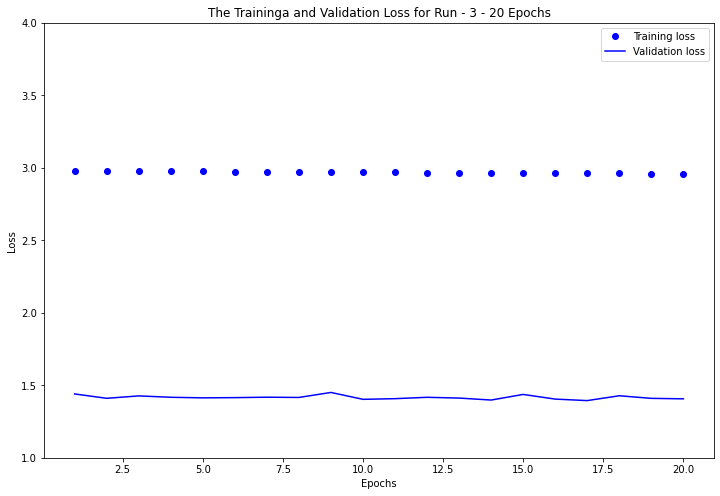

In [ ]:
np.save("PopComplexLSTM_REMI_run3_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI_run3_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI_run3_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI_run3_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,3,[1,4])

### 20 epoches

In [ ]:
PopComplexLSTM_REMI.load_state_dict(torch.load("/content/drive/MyDrive/WeightsREMI/PopComplexLSTM_REMI-run-3-val_loss-LAST.pth"))

<All keys matched successfully>

In [ ]:
optimizer = optim.AdamW(PopComplexLSTM_REMI.parameters(),lr=5e-7)
train_loss, val_loss = train(PopComplexLSTM_REMI,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="PopComplexLSTM_REMI")

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 2.957934
The mean validation loss is 1.419205

EPOCHS : 2/20 Loss : 2.957475
The mean validation loss is 1.400651

EPOCHS : 3/20 Loss : 2.956821
The mean validation loss is 1.409466

EPOCHS : 4/20 Loss : 2.955782
The mean validation loss is 1.433371

EPOCHS : 5/20 Loss : 2.955429
The mean validation loss is 1.404348

EPOCHS : 6/20 Loss : 2.955719
The mean validation loss is 1.412913

EPOCHS : 7/20 Loss : 2.954224
The mean validation loss is 1.405487

EPOCHS : 8/20 Loss : 2.954479
The mean validation loss is 1.407684

EPOCHS : 9/20 Loss : 2.952920
The mean validation loss is 1.415822

EPOCHS : 10/20 Loss : 2.952982
The mean validation loss is 1.413772

EPOCHS : 11/20 Loss : 2.952824
The mean validation loss is 1.419740

EPOCHS : 12/20 Loss : 2.952209
The mean validation loss is 1.406652

EPOCHS : 13/20 Loss : 2.952148
The mean validation loss is 1.398852

EPOCHS : 14/20 Loss : 2.950405
The mean validation loss is 1.411722

EPOCHS : 15/20 Loss : 2.950583
The mean val

In [ ]:
np.save("PopComplexLSTM_REMI_run4_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI_run4_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI_run4_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI_run4_valloss.npy /content/drive/MyDrive/losses


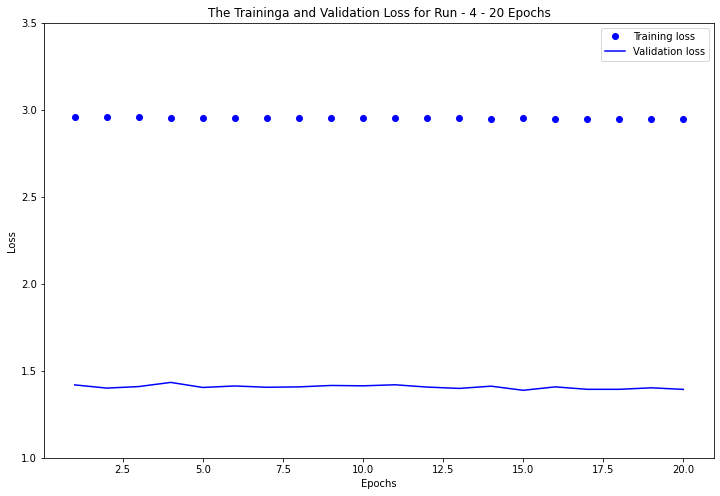

In [ ]:
plot_loss(train_loss,val_loss,4,[1,3.5])

### 20 epoches

In [ ]:
train_loss, val_loss = train(PopComplexLSTM_REMI,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="PopComplexLSTM_REMI")

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 2.947893
The mean validation loss is 1.401178

EPOCHS : 2/20 Loss : 2.947011
The mean validation loss is 1.386158

EPOCHS : 3/20 Loss : 2.946427
The mean validation loss is 1.407384

EPOCHS : 4/20 Loss : 2.947013
The mean validation loss is 1.407737

EPOCHS : 5/20 Loss : 2.946003
The mean validation loss is 1.416647

EPOCHS : 6/20 Loss : 2.945468
The mean validation loss is 1.437856

EPOCHS : 7/20 Loss : 2.945365
The mean validation loss is 1.421807

EPOCHS : 8/20 Loss : 2.944444
The mean validation loss is 1.423582

EPOCHS : 9/20 Loss : 2.944156
The mean validation loss is 1.411991

EPOCHS : 10/20 Loss : 2.943779
The mean validation loss is 1.409101

EPOCHS : 11/20 Loss : 2.942970
The mean validation loss is 1.390886

EPOCHS : 12/20 Loss : 2.943103
The mean validation loss is 1.403791

EPOCHS : 13/20 Loss : 2.942881
The mean validation loss is 1.396549

EPOCHS : 14/20 Loss : 2.941472
The mean validation loss is 1.411080

EPOCHS : 15/20 Loss : 2.942606
The mean val

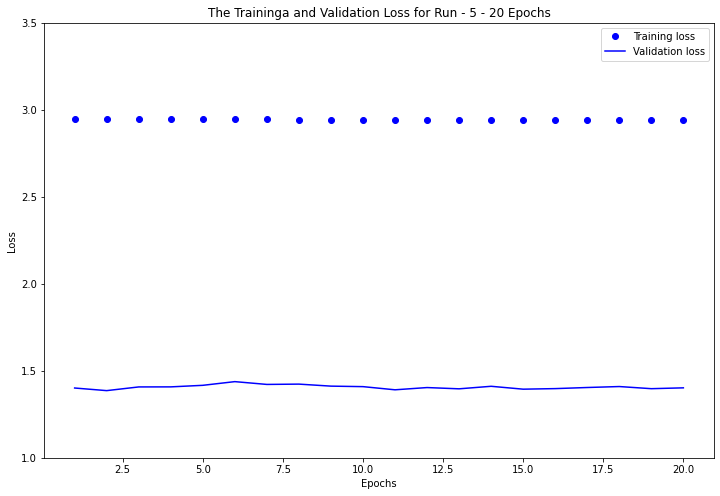

In [ ]:
np.save("PopComplexLSTM_REMI_run5_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI_run5_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI_run5_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI_run5_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,5,[1,3.5])

### 20 epoches

In [ ]:
optimizer = optim.AdamW(PopComplexLSTM_REMI.parameters(),lr=2e-7)
train_loss, val_loss = train(PopComplexLSTM_REMI,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',6,grad_clip=1.0,mname="PopComplexLSTM_REMI")

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 2.938525
The mean validation loss is 1.414764

EPOCHS : 2/20 Loss : 2.938593
The mean validation loss is 1.389253

EPOCHS : 3/20 Loss : 2.937944
The mean validation loss is 1.418015

EPOCHS : 4/20 Loss : 2.937939
The mean validation loss is 1.408071

EPOCHS : 5/20 Loss : 2.938725
The mean validation loss is 1.401938

EPOCHS : 6/20 Loss : 2.938327
The mean validation loss is 1.380918

EPOCHS : 7/20 Loss : 2.938595
The mean validation loss is 1.405741

EPOCHS : 8/20 Loss : 2.938477
The mean validation loss is 1.394110

EPOCHS : 9/20 Loss : 2.937562
The mean validation loss is 1.395975

EPOCHS : 10/20 Loss : 2.937745
The mean validation loss is 1.392824

EPOCHS : 11/20 Loss : 2.937591
The mean validation loss is 1.411253

EPOCHS : 12/20 Loss : 2.936768
The mean validation loss is 1.393832

EPOCHS : 13/20 Loss : 2.937287
The mean validation loss is 1.411019

EPOCHS : 14/20 Loss : 2.936763
The mean validation loss is 1.403355

EPOCHS : 15/20 Loss : 2.937180
The mean val

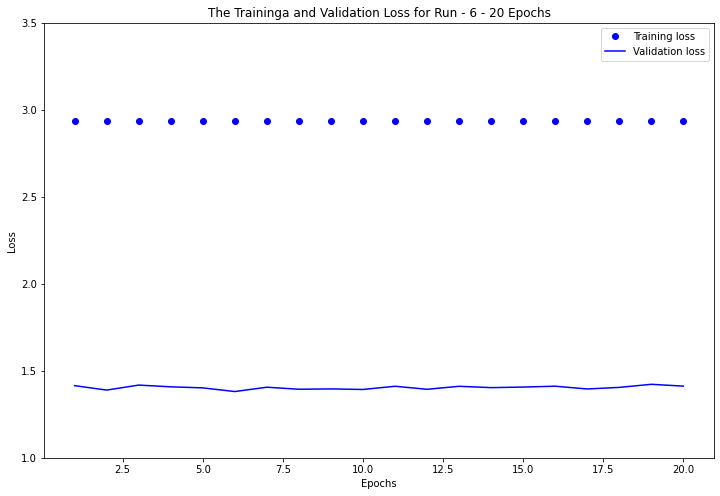

In [ ]:
np.save("PopComplexLSTM_REMI_run6_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI_run6_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI_run6_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI_run6_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,6,[1,3.5])

### 20 epoches

In [ ]:

train_loss, val_loss = train(PopComplexLSTM_REMI,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',7,grad_clip=1.0,mname="PopComplexLSTM_REMI")

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 2.934988
The mean validation loss is 1.420710

EPOCHS : 2/20 Loss : 2.934817
The mean validation loss is 1.390974

EPOCHS : 3/20 Loss : 2.935102
The mean validation loss is 1.408738

EPOCHS : 4/20 Loss : 2.934764
The mean validation loss is 1.435636

EPOCHS : 5/20 Loss : 2.934653
The mean validation loss is 1.408876

EPOCHS : 6/20 Loss : 2.935189
The mean validation loss is 1.391459

EPOCHS : 7/20 Loss : 2.935076
The mean validation loss is 1.416012

EPOCHS : 8/20 Loss : 2.934151
The mean validation loss is 1.414675

EPOCHS : 9/20 Loss : 2.934415
The mean validation loss is 1.394430

EPOCHS : 10/20 Loss : 2.934058
The mean validation loss is 1.414705

EPOCHS : 11/20 Loss : 2.934280
The mean validation loss is 1.402615

EPOCHS : 12/20 Loss : 2.933657
The mean validation loss is 1.401689

EPOCHS : 13/20 Loss : 2.933304
The mean validation loss is 1.393767

EPOCHS : 14/20 Loss : 2.933053
The mean validation loss is 1.393004

EPOCHS : 15/20 Loss : 2.933147
The mean val

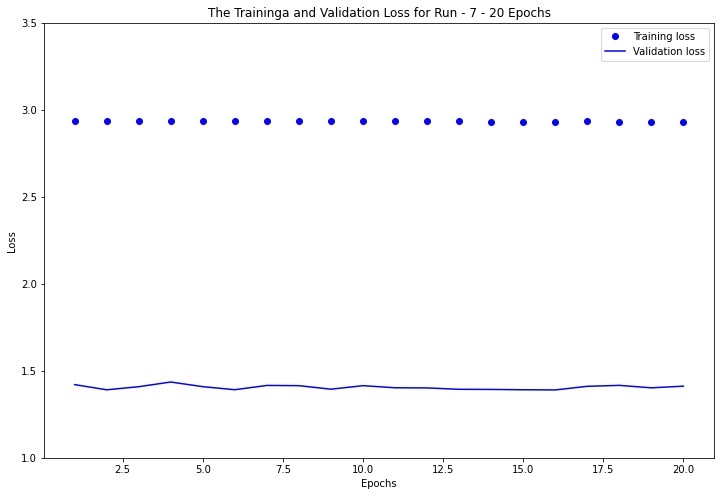

In [ ]:
np.save("PopComplexLSTM_REMI_run7_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI_run7_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI_run7_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI_run7_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,7,[1,3.5])

### 20 epoches

In [ ]:
train_loss, val_loss = train(PopComplexLSTM_REMI,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',8,grad_clip=1.0,mname="PopComplexLSTM_REMI")

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 2.932053
The mean validation loss is 1.404722

EPOCHS : 2/20 Loss : 2.932160
The mean validation loss is 1.402671

EPOCHS : 3/20 Loss : 2.932194
The mean validation loss is 1.402776

EPOCHS : 4/20 Loss : 2.931218
The mean validation loss is 1.390598

EPOCHS : 5/20 Loss : 2.931824
The mean validation loss is 1.398957

EPOCHS : 6/20 Loss : 2.931329
The mean validation loss is 1.406714

EPOCHS : 7/20 Loss : 2.931754
The mean validation loss is 1.381425

EPOCHS : 8/20 Loss : 2.930741
The mean validation loss is 1.382050

EPOCHS : 9/20 Loss : 2.930756
The mean validation loss is 1.381214

EPOCHS : 10/20 Loss : 2.930693
The mean validation loss is 1.418056

EPOCHS : 11/20 Loss : 2.930931
The mean validation loss is 1.391114

EPOCHS : 12/20 Loss : 2.930079
The mean validation loss is 1.394678

EPOCHS : 13/20 Loss : 2.929859
The mean validation loss is 1.398352

EPOCHS : 14/20 Loss : 2.930375
The mean validation loss is 1.391920

EPOCHS : 15/20 Loss : 2.930776
The mean val

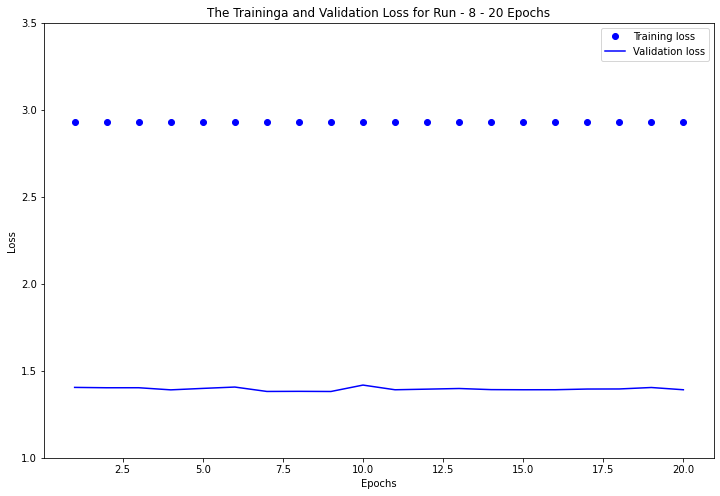

In [ ]:
np.save("PopComplexLSTM_REMI_run8_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI_run8_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI_run8_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI_run8_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,8,[1,3.5])

In [ ]:
del PopComplexLSTM_REMI

## ClassicalComplexLSTM

In [ ]:
ClassicalComplexLSTM_REMI = ComplexLSTM().cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ClassicalComplexLSTM_REMI.parameters(),lr=5e-6)

In [ ]:

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.97,verbose=True)

Adjusting learning rate of group 0 to 5.0000e-06.


In [ ]:
train_loss, val_loss = train(ClassicalComplexLSTM_REMI,train_dataloader,val_dataloader,10,10,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="ClassicalComplexLSTM_REMI")

  0%|          | 0/1700 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 4.765169
The mean validation loss is 4.333867

EPOCHS : 2/10 Loss : 4.051059
The mean validation loss is 3.844168

EPOCHS : 3/10 Loss : 3.629209
The mean validation loss is 3.461539

EPOCHS : 4/10 Loss : 3.340243
The mean validation loss is 3.231233

EPOCHS : 5/10 Loss : 3.154619
The mean validation loss is 3.094084

EPOCHS : 6/10 Loss : 3.050675
The mean validation loss is 3.045251

EPOCHS : 7/10 Loss : 2.995340
The mean validation loss is 2.987167

EPOCHS : 8/10 Loss : 2.957833
The mean validation loss is 2.939831

EPOCHS : 9/10 Loss : 2.930536
The mean validation loss is 2.951648

EPOCHS : 10/10 Loss : 2.906225
The mean validation loss is 2.932994



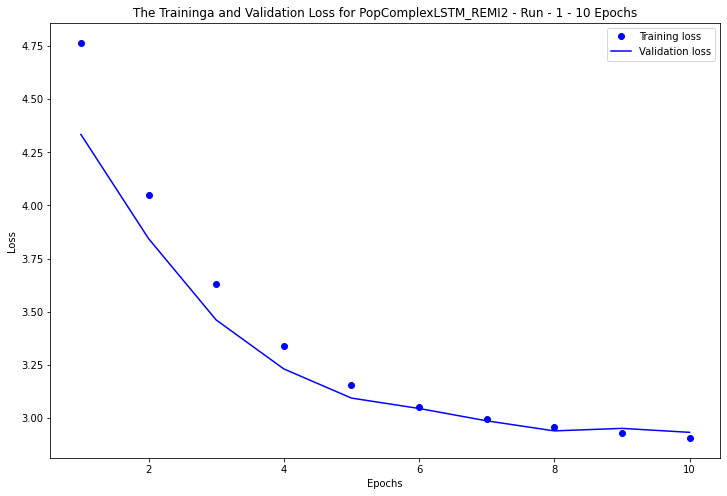

In [ ]:
np.save("ClassicalComplexLSTM_REMI_run1_trainloss.npy",np.array(train_loss))
!cp ClassicalComplexLSTM_REMI_run1_trainloss.npy /content/drive/MyDrive/losses
np.save("ClassicalComplexLSTM_REMI_run1_valloss.npy",np.array(val_loss))
!cp ClassicalComplexLSTM_REMI_run1_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,1)

In [ ]:
train_loss, val_loss = train(ClassicalComplexLSTM_REMI,train_dataloader,val_dataloader,10,10,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="ClassicalComplexLSTM_REMI")

  0%|          | 0/1700 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 2.892442
The mean validation loss is 2.909691

EPOCHS : 2/10 Loss : 2.880362
The mean validation loss is 2.902758

EPOCHS : 3/10 Loss : 2.869225
The mean validation loss is 2.886257

EPOCHS : 4/10 Loss : 2.857153
The mean validation loss is 2.881178

EPOCHS : 5/10 Loss : 2.849351
The mean validation loss is 2.885465

EPOCHS : 6/10 Loss : 2.840208
The mean validation loss is 2.839717

EPOCHS : 7/10 Loss : 2.831086
The mean validation loss is 2.857179

EPOCHS : 8/10 Loss : 2.824756
The mean validation loss is 2.851709

EPOCHS : 9/10 Loss : 2.816917
The mean validation loss is 2.831074

EPOCHS : 10/10 Loss : 2.811185
The mean validation loss is 2.830149



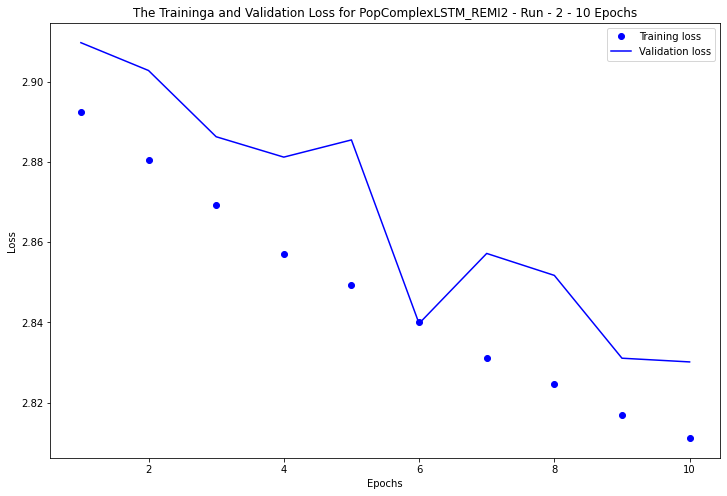

In [ ]:
np.save("ClassicalComplexLSTM_REMI_run2_trainloss.npy",np.array(train_loss))
!cp ClassicalComplexLSTM_REMI_run2_trainloss.npy /content/drive/MyDrive/losses
np.save("ClassicalComplexLSTM_REMI_run2_valloss.npy",np.array(val_loss))
!cp ClassicalComplexLSTM_REMI_run2_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,2)

In [ ]:
train_loss, val_loss = train(ClassicalComplexLSTM_REMI,train_dataloader,val_dataloader,10,10,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="ClassicalComplexLSTM_REMI")

  0%|          | 0/1700 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 2.806311
The mean validation loss is 2.829186

EPOCHS : 2/10 Loss : 2.801635
The mean validation loss is 2.821365

EPOCHS : 3/10 Loss : 2.795098
The mean validation loss is 2.795571

EPOCHS : 4/10 Loss : 2.787737
The mean validation loss is 2.814253

EPOCHS : 5/10 Loss : 2.786756
The mean validation loss is 2.819665

EPOCHS : 6/10 Loss : 2.782223
The mean validation loss is 2.814923

EPOCHS : 7/10 Loss : 2.778139
The mean validation loss is 2.788873

EPOCHS : 8/10 Loss : 2.770489
The mean validation loss is 2.794176

EPOCHS : 9/10 Loss : 2.769634
The mean validation loss is 2.800724

EPOCHS : 10/10 Loss : 2.766860
The mean validation loss is 2.805319



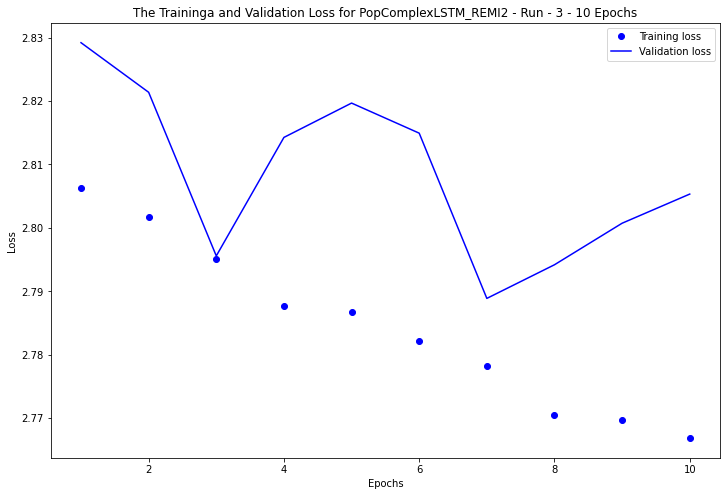

In [ ]:
np.save("ClassicalComplexLSTM_REMI_run3_trainloss.npy",np.array(train_loss))
!cp ClassicalComplexLSTM_REMI_run3_trainloss.npy /content/drive/MyDrive/losses
np.save("ClassicalComplexLSTM_REMI_run3_valloss.npy",np.array(val_loss))
!cp ClassicalComplexLSTM_REMI_run3_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,3)

In [ ]:
train_loss, val_loss = train(ClassicalComplexLSTM_REMI,train_dataloader,val_dataloader,10,10,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="ClassicalComplexLSTM_REMI")

  0%|          | 0/1700 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 2.761492
The mean validation loss is 2.770877

EPOCHS : 2/10 Loss : 2.760902
The mean validation loss is 2.761196

EPOCHS : 3/10 Loss : 2.757866
The mean validation loss is 2.794708

EPOCHS : 4/10 Loss : 2.754892
The mean validation loss is 2.775963

EPOCHS : 5/10 Loss : 2.751838
The mean validation loss is 2.773705

EPOCHS : 6/10 Loss : 2.749368
The mean validation loss is 2.773837

EPOCHS : 7/10 Loss : 2.747087
The mean validation loss is 2.756402

EPOCHS : 8/10 Loss : 2.741799
The mean validation loss is 2.769581

EPOCHS : 9/10 Loss : 2.739238
The mean validation loss is 2.735193

EPOCHS : 10/10 Loss : 2.738274
The mean validation loss is 2.750903



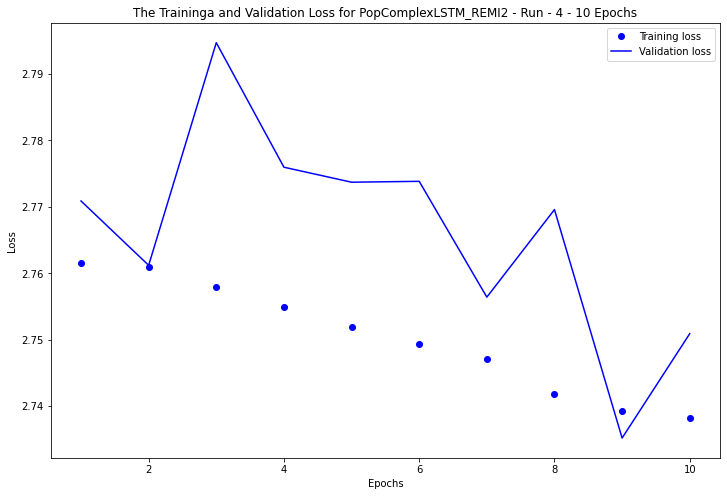

In [ ]:
np.save("ClassicalComplexLSTM_REMI_run4_trainloss.npy",np.array(train_loss))
!cp ClassicalComplexLSTM_REMI_run4_trainloss.npy /content/drive/MyDrive/losses
np.save("ClassicalComplexLSTM_REMI_run4_valloss.npy",np.array(val_loss))
!cp ClassicalComplexLSTM_REMI_run4_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,4)

In [ ]:
train_loss, val_loss = train(ClassicalComplexLSTM_REMI,train_dataloader,val_dataloader,10,10,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="ClassicalComplexLSTM_REMI")

  0%|          | 0/1700 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 2.736478
The mean validation loss is 2.770672

EPOCHS : 2/10 Loss : 2.735035
The mean validation loss is 2.771758

EPOCHS : 3/10 Loss : 2.732723
The mean validation loss is 2.753472

EPOCHS : 4/10 Loss : 2.730556
The mean validation loss is 2.760887

EPOCHS : 5/10 Loss : 2.729960
The mean validation loss is 2.741265

EPOCHS : 6/10 Loss : 2.728639
The mean validation loss is 2.738747

EPOCHS : 7/10 Loss : 2.724862
The mean validation loss is 2.750121

EPOCHS : 8/10 Loss : 2.721384
The mean validation loss is 2.746247

EPOCHS : 9/10 Loss : 2.721911
The mean validation loss is 2.754733

EPOCHS : 10/10 Loss : 2.720164
The mean validation loss is 2.732231



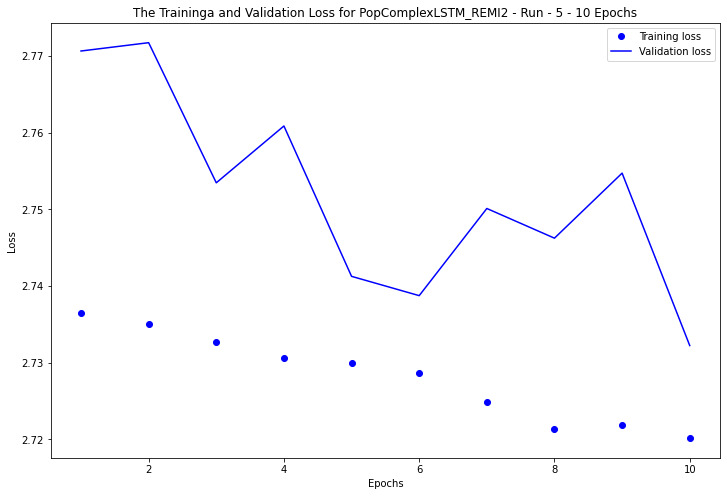

In [ ]:
np.save("ClassicalComplexLSTM_REMI_run5_trainloss.npy",np.array(train_loss))
!cp ClassicalComplexLSTM_REMI_run5_trainloss.npy /content/drive/MyDrive/losses
np.save("ClassicalComplexLSTM_REMI_run5_valloss.npy",np.array(val_loss))
!cp ClassicalComplexLSTM_REMI_run5_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,5)

In [ ]:
train_loss, val_loss = train(ClassicalComplexLSTM_REMI,train_dataloader,val_dataloader,10,10,
      loss_fun,optimizer,'cuda',6,grad_clip=1.0,mname="ClassicalComplexLSTM_REMI")

  0%|          | 0/1700 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 2.718748
The mean validation loss is 2.713625

EPOCHS : 2/10 Loss : 2.715670
The mean validation loss is 2.753213

EPOCHS : 3/10 Loss : 2.714391
The mean validation loss is 2.751878

EPOCHS : 4/10 Loss : 2.712862
The mean validation loss is 2.747070

EPOCHS : 5/10 Loss : 2.714304
The mean validation loss is 2.745689

EPOCHS : 6/10 Loss : 2.712394
The mean validation loss is 2.750780

EPOCHS : 7/10 Loss : 2.708502
The mean validation loss is 2.728050

EPOCHS : 8/10 Loss : 2.709870
The mean validation loss is 2.721524

EPOCHS : 9/10 Loss : 2.708644
The mean validation loss is 2.708788

EPOCHS : 10/10 Loss : 2.706110
The mean validation loss is 2.730818



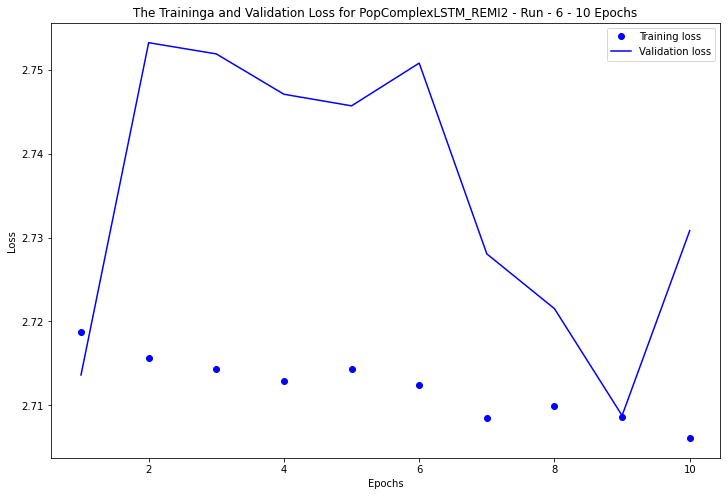

In [ ]:
np.save("ClassicalComplexLSTM_REMI_run6_trainloss.npy",np.array(train_loss))
!cp ClassicalComplexLSTM_REMI_run6_trainloss.npy /content/drive/MyDrive/losses
np.save("ClassicalComplexLSTM_REMI_run6_valloss.npy",np.array(val_loss))
!cp ClassicalComplexLSTM_REMI_run6_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,6)

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.97,verbose=True)

Adjusting learning rate of group 0 to 5.0000e-06.


## ComplexLSTM2 - with 0.01 events dropout

In [ ]:
class ComplexLSTM2(nn.Module):
    def __init__(self, num_embeddings = 218, embed_size = 512, hidden_size = 2048, 
                  num_class = 218, layers = 2):
        super(ComplexLSTM2, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        self.layers = layers
        self.embedding_layer = nn.Embedding(num_embeddings,embed_size,padding_idx=0)
        self.layernorm_encoder = nn.LayerNorm(embed_size)
        self.layernorm_lstm = nn.LayerNorm(hidden_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,layers)
        self.final = nn.Linear(hidden_size,num_class)
        self.final = nn.Linear(hidden_size,512)
        self.final2 = nn.Linear(512,num_class)
        self.relu = nn.ReLU()
        
    def forward(self,sequences,hidden=None):
        # seq shape (batch,seq_len,88)
        # embedding layer: ignored padding_idx which is 0
        notes_embedded = self.embedding_layer(sequences) # shape (batch,seq_len,embed_size)
        

        notes_lnormed = self.layernorm_encoder(notes_embedded)
        notes_lnormed = nn.Dropout(0.01)(notes_lnormed)

        
        # output shape (batch,seq_len,hidden_size)
        output, hidden = self.lstm(notes_lnormed,hidden)
        
        #output_lnormed = self.layernorm_lstm(output.permute(1,2,0).contiguous())
        output_lnormed = self.layernorm_lstm(output)
        output_lnormed = nn.Dropout(0.01)(output_lnormed)
        

        
        # only take the final 1000
        #output_lnormed = output_lnormed[:,-1000:,:] 
        
        # final shape (batch,200,num_class)
        #final = self.final(output_lnormed.permute(2,0,1))
        final = self.final(output_lnormed) # final (batch,200,hidden_size) --> 
                                            #                 (batch,200,88)
        
        final = self.relu(final)
        final = nn.Dropout(0.5)(final)
        final = self.final2(final)
        
        return final, hidden

In [ ]:
PopComplexLSTM_REMI2 = ComplexLSTM2().cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(PopComplexLSTM_REMI2.parameters(),lr=5e-6)

### 120 epochs with scheduler

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.97,verbose=True)

Adjusting learning rate of group 0 to 5.0000e-06.


In [ ]:
train_loss, val_loss = train(PopComplexLSTM_REMI2,train_dataloader,val_dataloader,100,100,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="PopComplexLSTM_REMI2",scheduler=scheduler)

  0%|          | 0/9700 [00:00<?, ?it/s]

EPOCHS : 1/100 Loss : 4.973814
The mean validation loss is 2.884965

Adjusting learning rate of group 0 to 4.8500e-06.
EPOCHS : 2/100 Loss : 4.367744
The mean validation loss is 2.207319

Adjusting learning rate of group 0 to 4.7045e-06.
EPOCHS : 3/100 Loss : 4.003691
The mean validation loss is 1.875434

Adjusting learning rate of group 0 to 4.5634e-06.
EPOCHS : 4/100 Loss : 3.674298
The mean validation loss is 1.734938

Adjusting learning rate of group 0 to 4.4265e-06.
EPOCHS : 5/100 Loss : 3.450606
The mean validation loss is 1.602601

Adjusting learning rate of group 0 to 4.2937e-06.
EPOCHS : 6/100 Loss : 3.313815
The mean validation loss is 1.539554

Adjusting learning rate of group 0 to 4.1649e-06.
EPOCHS : 7/100 Loss : 3.234871
The mean validation loss is 1.526541

Adjusting learning rate of group 0 to 4.0399e-06.
EPOCHS : 8/100 Loss : 3.184195
The mean validation loss is 1.503758

Adjusting learning rate of group 0 to 3.9187e-06.
EPOCHS : 9/100 Loss : 3.150201
The mean validati

In [ ]:
np.save("PopComplexLSTM_REMI2_run1_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI2_run1_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI2_run1_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI2_run1_valloss.npy /content/drive/MyDrive/losses

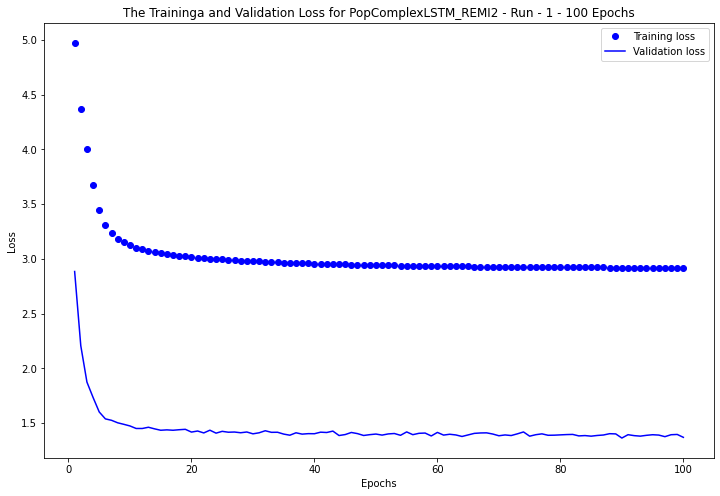

In [ ]:
plot_loss(train_loss,val_loss,run=1,modelname="PopComplexLSTM_REMI2",ylimit=None)

## training with weighted loss

In [ ]:
weights = np.ones((218))
weights[2:89]=2
weights[0]=0
weights=torch.cuda.FloatTensor(weights)

loss_fun = nn.CrossEntropyLoss(weights)

In [ ]:
optimizer = optim.AdamW(PopComplexLSTM_REMI2.parameters(),lr=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.97,verbose=True)

Adjusting learning rate of group 0 to 1.0000e-06.


In [ ]:
train_loss, val_loss = train(PopComplexLSTM_REMI2,train_dataloader,val_dataloader,30,30,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="PopComplexLSTM_REMI2",scheduler=scheduler)

  0%|          | 0/2910 [00:00<?, ?it/s]

EPOCHS : 1/30 Loss : 3.475879
The mean validation loss is 3.515543

Adjusting learning rate of group 0 to 9.7000e-07.
EPOCHS : 2/30 Loss : 3.469621
The mean validation loss is 3.521906

Adjusting learning rate of group 0 to 9.4090e-07.
EPOCHS : 3/30 Loss : 3.468022
The mean validation loss is 3.511648

Adjusting learning rate of group 0 to 9.1267e-07.
EPOCHS : 4/30 Loss : 3.467116
The mean validation loss is 3.508037

Adjusting learning rate of group 0 to 8.8529e-07.
EPOCHS : 5/30 Loss : 3.466954
The mean validation loss is 3.519947

Adjusting learning rate of group 0 to 8.5873e-07.
EPOCHS : 6/30 Loss : 3.464417
The mean validation loss is 3.510989

Adjusting learning rate of group 0 to 8.3297e-07.
EPOCHS : 7/30 Loss : 3.463259
The mean validation loss is 3.522128

Adjusting learning rate of group 0 to 8.0798e-07.
EPOCHS : 8/30 Loss : 3.463681
The mean validation loss is 3.494958

Adjusting learning rate of group 0 to 7.8374e-07.
EPOCHS : 9/30 Loss : 3.463153
The mean validation loss i

In [ ]:
np.save("PopComplexLSTM_REMI2_run2_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI2_run2_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI2_run2_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI2_run2_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,run=1,modelname="PopComplexLSTM_REMI2",ylimit=None)

## PopComplexLSTM3 - with weighted weights

In [ ]:
PopComplexLSTM_REMI3 = ComplexLSTM().cuda()
weights = np.ones((218))
weights[2:89]=2
weights[0]=0
weights=torch.cuda.FloatTensor(weights)

loss_fun = nn.CrossEntropyLoss(weights)
optimizer = optim.AdamW(PopComplexLSTM_REMI3.parameters(),lr=2e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.97,verbose=True)

Adjusting learning rate of group 0 to 2.0000e-06.


In [ ]:
train_loss, val_loss = train(PopComplexLSTM_REMI3,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="PopComplexLSTM_REMI3",scheduler=scheduler)

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 5.319215
The mean validation loss is 5.200502

Adjusting learning rate of group 0 to 1.9400e-06.
EPOCHS : 2/20 Loss : 5.101586
The mean validation loss is 4.999096

Adjusting learning rate of group 0 to 1.8818e-06.
EPOCHS : 3/20 Loss : 4.920815
The mean validation loss is 4.827957

Adjusting learning rate of group 0 to 1.8253e-06.
EPOCHS : 4/20 Loss : 4.787695
The mean validation loss is 4.690305

Adjusting learning rate of group 0 to 1.7706e-06.
EPOCHS : 5/20 Loss : 4.680423
The mean validation loss is 4.589823

Adjusting learning rate of group 0 to 1.7175e-06.
EPOCHS : 6/20 Loss : 4.578890
The mean validation loss is 4.484251

Adjusting learning rate of group 0 to 1.6659e-06.
EPOCHS : 7/20 Loss : 4.482825
The mean validation loss is 4.374358

Adjusting learning rate of group 0 to 1.6160e-06.
EPOCHS : 8/20 Loss : 4.389425
The mean validation loss is 4.285894

Adjusting learning rate of group 0 to 1.5675e-06.
EPOCHS : 9/20 Loss : 4.299526
The mean validation loss i

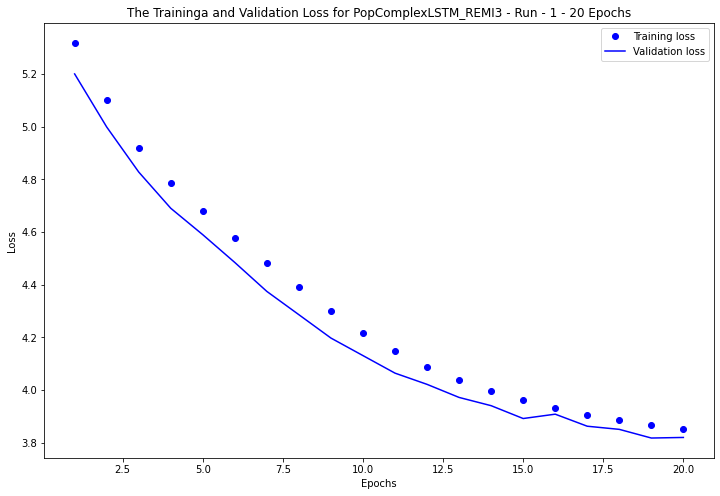

In [ ]:
np.save("PopComplexLSTM_REMI3_run1_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI3_run1_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI3_run1_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI3_run1_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,run=1,modelname="PopComplexLSTM_REMI3",ylimit=None)

In [ ]:
train_loss, val_loss = train(PopComplexLSTM_REMI3,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="PopComplexLSTM_REMI3",scheduler=scheduler)

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 3.837580
The mean validation loss is 3.796535

Adjusting learning rate of group 0 to 1.0550e-06.
EPOCHS : 2/20 Loss : 3.827583
The mean validation loss is 3.802179

Adjusting learning rate of group 0 to 1.0233e-06.
EPOCHS : 3/20 Loss : 3.813459
The mean validation loss is 3.785925

Adjusting learning rate of group 0 to 9.9261e-07.
EPOCHS : 4/20 Loss : 3.805317
The mean validation loss is 3.751130

Adjusting learning rate of group 0 to 9.6283e-07.
EPOCHS : 5/20 Loss : 3.796636
The mean validation loss is 3.769494

Adjusting learning rate of group 0 to 9.3395e-07.
EPOCHS : 6/20 Loss : 3.787404
The mean validation loss is 3.749548

Adjusting learning rate of group 0 to 9.0593e-07.
EPOCHS : 7/20 Loss : 3.780325
The mean validation loss is 3.745705

Adjusting learning rate of group 0 to 8.7875e-07.
EPOCHS : 8/20 Loss : 3.773798
The mean validation loss is 3.761540

Adjusting learning rate of group 0 to 8.5239e-07.
EPOCHS : 9/20 Loss : 3.767016
The mean validation loss i

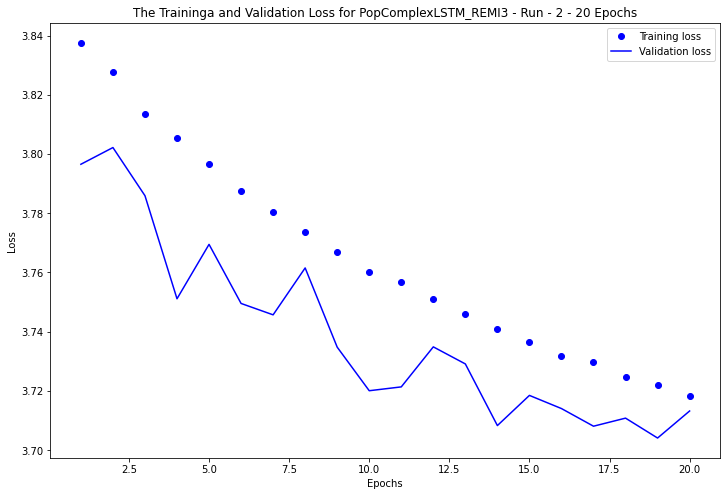

In [ ]:
np.save("PopComplexLSTM_REMI3_run2_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI3_run2_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI3_run2_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI3_run2_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,run=2,modelname="PopComplexLSTM_REMI3",ylimit=None)

In [ ]:
train_loss, val_loss = train(PopComplexLSTM_REMI3,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="PopComplexLSTM_REMI3",scheduler=scheduler)

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 3.715431
The mean validation loss is 3.688322

Adjusting learning rate of group 0 to 5.7368e-07.
EPOCHS : 2/20 Loss : 3.712017
The mean validation loss is 3.688677

Adjusting learning rate of group 0 to 5.5647e-07.
EPOCHS : 3/20 Loss : 3.709176
The mean validation loss is 3.694430

Adjusting learning rate of group 0 to 5.3978e-07.
EPOCHS : 4/20 Loss : 3.706374
The mean validation loss is 3.690780

Adjusting learning rate of group 0 to 5.2358e-07.
EPOCHS : 5/20 Loss : 3.704660
The mean validation loss is 3.674132

Adjusting learning rate of group 0 to 5.0788e-07.
EPOCHS : 6/20 Loss : 3.700792
The mean validation loss is 3.672661

Adjusting learning rate of group 0 to 4.9264e-07.
EPOCHS : 7/20 Loss : 3.698570
The mean validation loss is 3.668440

Adjusting learning rate of group 0 to 4.7786e-07.
EPOCHS : 8/20 Loss : 3.696874
The mean validation loss is 3.680014

Adjusting learning rate of group 0 to 4.6353e-07.
EPOCHS : 9/20 Loss : 3.695052
The mean validation loss i

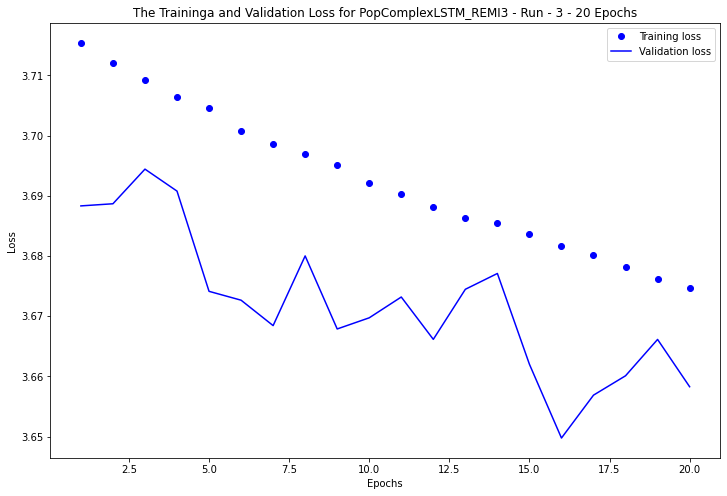

In [ ]:
np.save("PopComplexLSTM_REMI3_run3_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI3_run3_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI3_run3_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI3_run3_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,run=3,modelname="PopComplexLSTM_REMI3",ylimit=None)

In [ ]:
train_loss, val_loss = train(PopComplexLSTM_REMI3,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="PopComplexLSTM_REMI3",scheduler=scheduler)

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 3.674922
The mean validation loss is 3.658072

Adjusting learning rate of group 0 to 3.1196e-07.
EPOCHS : 2/20 Loss : 3.673213
The mean validation loss is 3.655146

Adjusting learning rate of group 0 to 3.0261e-07.
EPOCHS : 3/20 Loss : 3.671957
The mean validation loss is 3.652697

Adjusting learning rate of group 0 to 2.9353e-07.
EPOCHS : 4/20 Loss : 3.670830
The mean validation loss is 3.667397

Adjusting learning rate of group 0 to 2.8472e-07.
EPOCHS : 5/20 Loss : 3.669087
The mean validation loss is 3.660088

Adjusting learning rate of group 0 to 2.7618e-07.
EPOCHS : 6/20 Loss : 3.667798
The mean validation loss is 3.652172

Adjusting learning rate of group 0 to 2.6789e-07.
EPOCHS : 7/20 Loss : 3.666849
The mean validation loss is 3.656259

Adjusting learning rate of group 0 to 2.5986e-07.
EPOCHS : 8/20 Loss : 3.667012
The mean validation loss is 3.641946

Adjusting learning rate of group 0 to 2.5206e-07.
EPOCHS : 9/20 Loss : 3.665689
The mean validation loss i

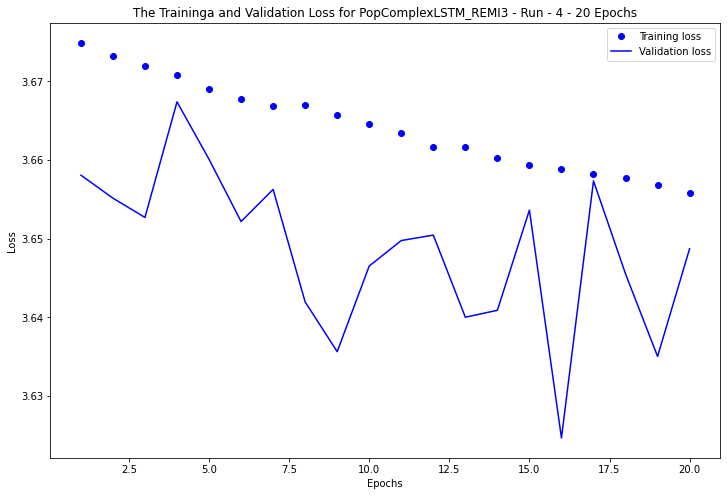

In [ ]:
np.save("PopComplexLSTM_REMI3_run4_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI3_run4_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI3_run4_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI3_run4_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,run=4,modelname="PopComplexLSTM_REMI3",ylimit=None)

In [ ]:
train_loss, val_loss = train(PopComplexLSTM_REMI3,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="PopComplexLSTM_REMI3",scheduler=scheduler)

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 3.655237
The mean validation loss is 3.666488

Adjusting learning rate of group 0 to 1.6964e-07.
EPOCHS : 2/20 Loss : 3.654751
The mean validation loss is 3.618906

Adjusting learning rate of group 0 to 1.6456e-07.
EPOCHS : 3/20 Loss : 3.653308
The mean validation loss is 3.628877

Adjusting learning rate of group 0 to 1.5962e-07.
EPOCHS : 4/20 Loss : 3.652930
The mean validation loss is 3.634895

Adjusting learning rate of group 0 to 1.5483e-07.
EPOCHS : 5/20 Loss : 3.653440
The mean validation loss is 3.634529

Adjusting learning rate of group 0 to 1.5019e-07.
EPOCHS : 6/20 Loss : 3.652146
The mean validation loss is 3.641203

Adjusting learning rate of group 0 to 1.4568e-07.
EPOCHS : 7/20 Loss : 3.650780
The mean validation loss is 3.631412

Adjusting learning rate of group 0 to 1.4131e-07.
EPOCHS : 8/20 Loss : 3.651386
The mean validation loss is 3.621296

Adjusting learning rate of group 0 to 1.3707e-07.
EPOCHS : 9/20 Loss : 3.650842
The mean validation loss i

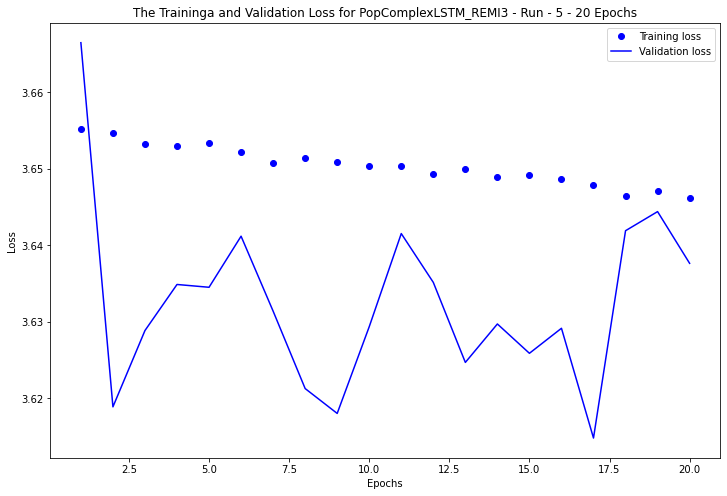

In [ ]:
np.save("PopComplexLSTM_REMI3_run5_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI3_run5_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI3_run5_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI3_run5_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,run=5,modelname="PopComplexLSTM_REMI3",ylimit=None)

In [ ]:
train_loss, val_loss = train(PopComplexLSTM_REMI3,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',6,grad_clip=1.0,mname="PopComplexLSTM_REMI3",scheduler=scheduler)

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 3.645713
The mean validation loss is 3.621672

Adjusting learning rate of group 0 to 9.2252e-08.
EPOCHS : 2/20 Loss : 3.645834
The mean validation loss is 3.636587

Adjusting learning rate of group 0 to 8.9484e-08.
EPOCHS : 3/20 Loss : 3.645286
The mean validation loss is 3.631139

Adjusting learning rate of group 0 to 8.6800e-08.
EPOCHS : 4/20 Loss : 3.644104
The mean validation loss is 3.625244

Adjusting learning rate of group 0 to 8.4196e-08.
EPOCHS : 5/20 Loss : 3.644284
The mean validation loss is 3.623731

Adjusting learning rate of group 0 to 8.1670e-08.
EPOCHS : 6/20 Loss : 3.644410
The mean validation loss is 3.632291

Adjusting learning rate of group 0 to 7.9220e-08.
EPOCHS : 7/20 Loss : 3.643436
The mean validation loss is 3.628574

Adjusting learning rate of group 0 to 7.6843e-08.
EPOCHS : 8/20 Loss : 3.644069
The mean validation loss is 3.632364

Adjusting learning rate of group 0 to 7.4538e-08.
EPOCHS : 9/20 Loss : 3.643536
The mean validation loss i

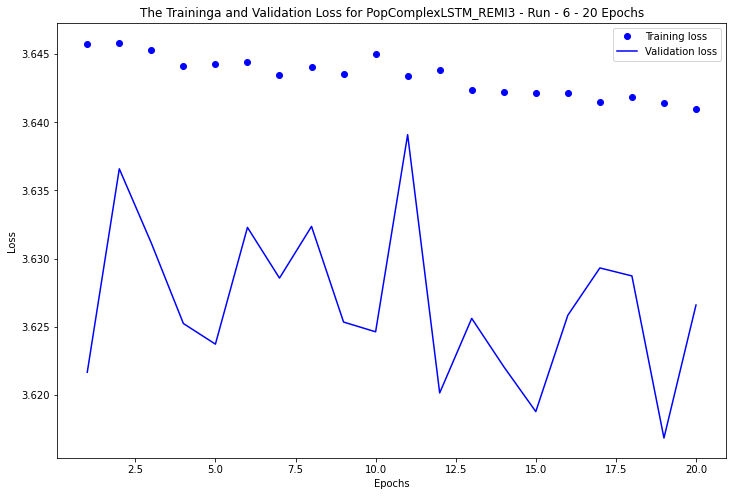

In [ ]:
np.save("PopComplexLSTM_REMI3_run6_trainloss.npy",np.array(train_loss))
!cp PopComplexLSTM_REMI3_run6_trainloss.npy /content/drive/MyDrive/losses
np.save("PopComplexLSTM_REMI3_run6_valloss.npy",np.array(val_loss))
!cp PopComplexLSTM_REMI3_run6_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,run=6,modelname="PopComplexLSTM_REMI3",ylimit=None)

# SimpleLSTM

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, num_embeddings = 218, embed_size = 128, hidden_size = 512, 
                  num_class = 218, layers = 1):
        super(SimpleLSTM, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        self.layers = layers
        self.embedding_layer = nn.Embedding(num_embeddings,embed_size,padding_idx=0)
        self.layernorm_encoder = nn.LayerNorm(embed_size)
        self.layernorm_lstm = nn.LayerNorm(hidden_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,layers)
        self.final = nn.Linear(hidden_size,num_class)
        self.relu = nn.ReLU()
        
    def forward(self,sequences,hidden=None):
        # seq shape (batch,seq_len,88)
        # embedding layer: ignored padding_idx which is 0
        notes_embedded = self.embedding_layer(sequences) # shape (batch,seq_len,embed_size)
        

        notes_lnormed = self.layernorm_encoder(notes_embedded)
        notes_lnormed = nn.Dropout(0.3)(notes_lnormed)

        
        # output shape (batch,seq_len,hidden_size)
        output, hidden = self.lstm(notes_lnormed,hidden)
        
        #output_lnormed = self.layernorm_lstm(output.permute(1,2,0).contiguous())
        output_lnormed = self.layernorm_lstm(output)
        output_lnormed = nn.Dropout(0.3)(output_lnormed)
        
        # final shape (batch,200,num_class)
        #final = self.final(output_lnormed.permute(2,0,1))
        final = self.final(output_lnormed) # final (batch,200,hidden_size) --> 
                                            #                 (batch,200,88)
        
        
        return final, hidden

## PopSimpleLSTM1 - 0.0046

In [ ]:
del PopSimpleLSTM_REMI

In [ ]:
PopSimpleLSTM_REMI = SimpleLSTM().cuda()

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(PopSimpleLSTM_REMI.parameters(),lr=2e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.99,verbose=True)

Adjusting learning rate of group 0 to 2.0000e-06.


In [ ]:
train_loss, val_loss = train(PopSimpleLSTM_REMI,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="PopSimpleLSTM_REMI",scheduler=scheduler)

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 5.637102
The mean validation loss is 5.810050

Adjusting learning rate of group 0 to 1.9800e-06.
EPOCHS : 2/20 Loss : 5.568336
The mean validation loss is 5.592870

Adjusting learning rate of group 0 to 1.9602e-06.
EPOCHS : 3/20 Loss : 5.500699
The mean validation loss is 5.385460

Adjusting learning rate of group 0 to 1.9406e-06.
EPOCHS : 4/20 Loss : 5.430066
The mean validation loss is 5.148407

Adjusting learning rate of group 0 to 1.9212e-06.
EPOCHS : 5/20 Loss : 5.364181
The mean validation loss is 4.929697

Adjusting learning rate of group 0 to 1.9020e-06.
EPOCHS : 6/20 Loss : 5.294756
The mean validation loss is 4.720569

Adjusting learning rate of group 0 to 1.8830e-06.
EPOCHS : 7/20 Loss : 5.229955
The mean validation loss is 4.506041

Adjusting learning rate of group 0 to 1.8641e-06.
EPOCHS : 8/20 Loss : 5.159350
The mean validation loss is 4.297411

Adjusting learning rate of group 0 to 1.8455e-06.
EPOCHS : 9/20 Loss : 5.087394
The mean validation loss i

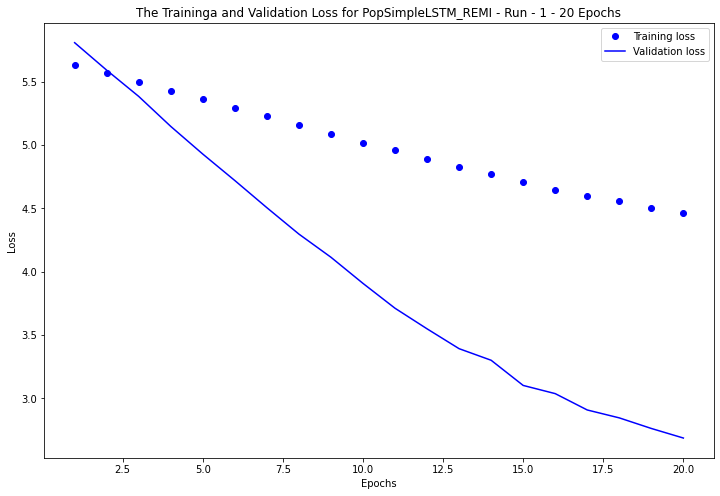

In [ ]:
np.save("PopSimpleLSTM_REMI_run1_trainloss.npy",np.array(train_loss))
!cp PopSimpleLSTM_REMI_run1_trainloss.npy /content/drive/MyDrive/losses
np.save("PopSimpleLSTM_REMI_run1_valloss.npy",np.array(val_loss))
!cp PopSimpleLSTM_REMI_run1_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,run=1,modelname="PopSimpleLSTM_REMI",ylimit=None)

In [ ]:
train_loss, val_loss = train(PopSimpleLSTM_REMI,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="PopSimpleLSTM_REMI",scheduler=scheduler)

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 4.424314
The mean validation loss is 2.640860

Adjusting learning rate of group 0 to 1.6195e-06.
EPOCHS : 2/20 Loss : 4.382191
The mean validation loss is 2.576895

Adjusting learning rate of group 0 to 1.6033e-06.
EPOCHS : 3/20 Loss : 4.347230
The mean validation loss is 2.537158

Adjusting learning rate of group 0 to 1.5872e-06.
EPOCHS : 4/20 Loss : 4.315725
The mean validation loss is 2.484383

Adjusting learning rate of group 0 to 1.5714e-06.
EPOCHS : 5/20 Loss : 4.285218
The mean validation loss is 2.467582

Adjusting learning rate of group 0 to 1.5556e-06.
EPOCHS : 6/20 Loss : 4.257420
The mean validation loss is 2.424629

Adjusting learning rate of group 0 to 1.5401e-06.
EPOCHS : 7/20 Loss : 4.233421
The mean validation loss is 2.412371

Adjusting learning rate of group 0 to 1.5247e-06.
EPOCHS : 8/20 Loss : 4.201418
The mean validation loss is 2.361832

Adjusting learning rate of group 0 to 1.5094e-06.
EPOCHS : 9/20 Loss : 4.173390
The mean validation loss i

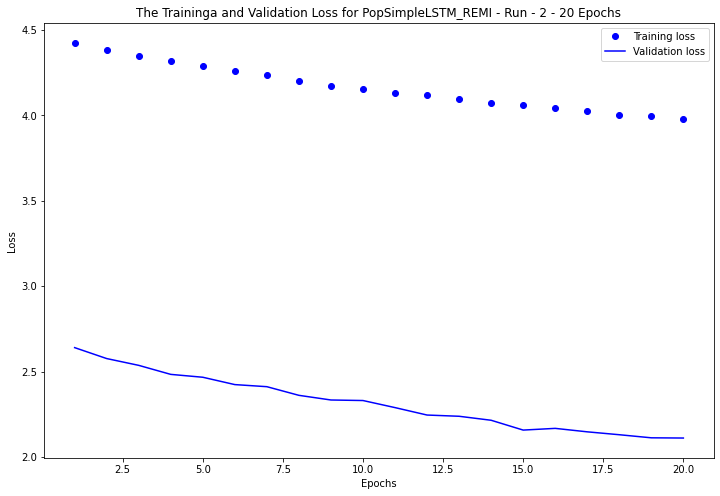

In [ ]:
np.save("PopSimpleLSTM_REMI_run2_trainloss.npy",np.array(train_loss))
!cp PopSimpleLSTM_REMI_run2_trainloss.npy /content/drive/MyDrive/losses
np.save("PopSimpleLSTM_REMI_run2_valloss.npy",np.array(val_loss))
!cp PopSimpleLSTM_REMI_run2_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,run=2,modelname="PopSimpleLSTM_REMI",ylimit=None)

In [ ]:
train_loss, val_loss = train(PopSimpleLSTM_REMI,train_dataloader,val_dataloader,20,20,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="PopSimpleLSTM_REMI",scheduler=scheduler)

  0%|          | 0/1940 [00:00<?, ?it/s]

EPOCHS : 1/20 Loss : 3.962206
The mean validation loss is 2.089152

Adjusting learning rate of group 0 to 1.3246e-06.
EPOCHS : 2/20 Loss : 3.945395
The mean validation loss is 2.058498

Adjusting learning rate of group 0 to 1.3113e-06.
EPOCHS : 3/20 Loss : 3.931081
The mean validation loss is 2.049383

Adjusting learning rate of group 0 to 1.2982e-06.
EPOCHS : 4/20 Loss : 3.916310
The mean validation loss is 2.050136

Adjusting learning rate of group 0 to 1.2852e-06.
EPOCHS : 5/20 Loss : 3.904791
The mean validation loss is 1.996862

Adjusting learning rate of group 0 to 1.2724e-06.
EPOCHS : 6/20 Loss : 3.894036
The mean validation loss is 2.013355

Adjusting learning rate of group 0 to 1.2596e-06.
EPOCHS : 7/20 Loss : 3.881075
The mean validation loss is 1.980525

Adjusting learning rate of group 0 to 1.2471e-06.
EPOCHS : 8/20 Loss : 3.858930
The mean validation loss is 2.007051

Adjusting learning rate of group 0 to 1.2346e-06.
EPOCHS : 9/20 Loss : 3.850410
The mean validation loss i

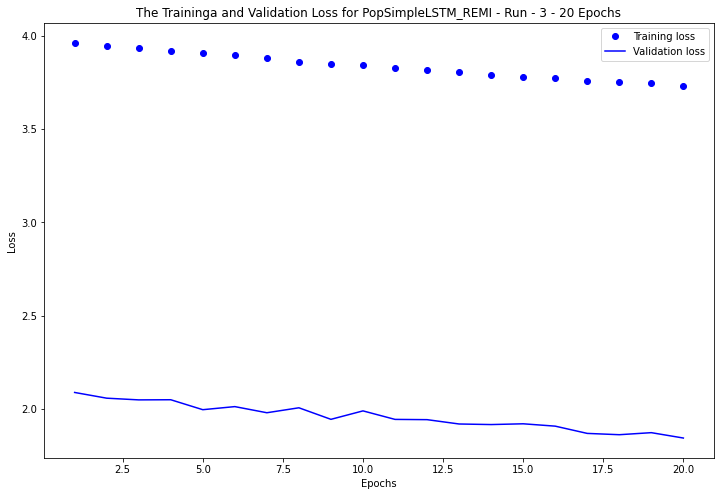

In [ ]:
np.save("PopSimpleLSTM_REMI_run3_trainloss.npy",np.array(train_loss))
!cp PopSimpleLSTM_REMI_run3_trainloss.npy /content/drive/MyDrive/losses
np.save("PopSimpleLSTM_REMI_run3_valloss.npy",np.array(val_loss))
!cp PopSimpleLSTM_REMI_run3_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,run=3,modelname="PopSimpleLSTM_REMI",ylimit=None)

In [ ]:
train_loss, val_loss = train(PopSimpleLSTM_REMI,train_dataloader,val_dataloader,200,200,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="PopSimpleLSTM_REMI",scheduler=scheduler)

  0%|          | 0/19400 [00:00<?, ?it/s]

EPOCHS : 1/200 Loss : 3.721388
The mean validation loss is 1.830845

Adjusting learning rate of group 0 to 1.0834e-06.
EPOCHS : 2/200 Loss : 3.711700
The mean validation loss is 1.812511

Adjusting learning rate of group 0 to 1.0725e-06.
EPOCHS : 3/200 Loss : 3.705968
The mean validation loss is 1.846550

Adjusting learning rate of group 0 to 1.0618e-06.
EPOCHS : 4/200 Loss : 3.699253
The mean validation loss is 1.837116

Adjusting learning rate of group 0 to 1.0512e-06.
EPOCHS : 5/200 Loss : 3.685501
The mean validation loss is 1.844880

Adjusting learning rate of group 0 to 1.0407e-06.
EPOCHS : 6/200 Loss : 3.674535
The mean validation loss is 1.832073

Adjusting learning rate of group 0 to 1.0303e-06.
EPOCHS : 7/200 Loss : 3.668280
The mean validation loss is 1.818727

Adjusting learning rate of group 0 to 1.0200e-06.
EPOCHS : 8/200 Loss : 3.658552
The mean validation loss is 1.783113

Adjusting learning rate of group 0 to 1.0098e-06.
EPOCHS : 9/200 Loss : 3.653837
The mean validati

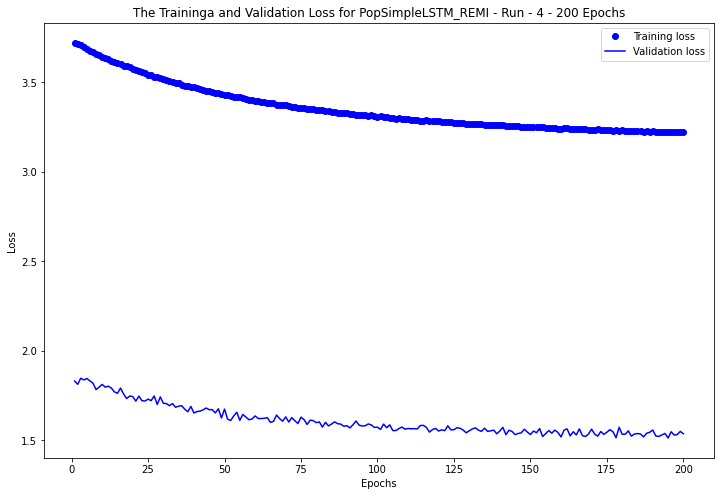

In [ ]:
np.save("PopSimpleLSTM_REMI_run4_trainloss.npy",np.array(train_loss))
!cp PopSimpleLSTM_REMI_run4_trainloss.npy /content/drive/MyDrive/losses
np.save("PopSimpleLSTM_REMI_run4_valloss.npy",np.array(val_loss))
!cp PopSimpleLSTM_REMI_run4_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,run=4,modelname="PopSimpleLSTM_REMI",ylimit=None)

In [ ]:
optimizer = optim.AdamW(PopSimpleLSTM_REMI.parameters(),lr=5e-7)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5.0, gamma=0.99,verbose=True)

Adjusting learning rate of group 0 to 5.0000e-07.


In [ ]:
train_loss, val_loss = train(PopSimpleLSTM_REMI,train_dataloader,val_dataloader,200,200,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="PopSimpleLSTM_REMI",scheduler=scheduler)

  0%|          | 0/19400 [00:00<?, ?it/s]

EPOCHS : 1/200 Loss : 3.218710
The mean validation loss is 1.533081

Adjusting learning rate of group 0 to 5.0000e-07.
EPOCHS : 2/200 Loss : 3.217897
The mean validation loss is 1.532400

Adjusting learning rate of group 0 to 5.0000e-07.
EPOCHS : 3/200 Loss : 3.215555
The mean validation loss is 1.540262

Adjusting learning rate of group 0 to 5.0000e-07.
EPOCHS : 4/200 Loss : 3.214875
The mean validation loss is 1.541565

Adjusting learning rate of group 0 to 5.0000e-07.
EPOCHS : 5/200 Loss : 3.214362
The mean validation loss is 1.516156

Adjusting learning rate of group 0 to 4.9500e-07.
EPOCHS : 6/200 Loss : 3.212302
The mean validation loss is 1.530188

Adjusting learning rate of group 0 to 4.9500e-07.
EPOCHS : 7/200 Loss : 3.211641
The mean validation loss is 1.536705

Adjusting learning rate of group 0 to 4.9500e-07.
EPOCHS : 8/200 Loss : 3.209793
The mean validation loss is 1.512426

Adjusting learning rate of group 0 to 4.9500e-07.
EPOCHS : 9/200 Loss : 3.208994
The mean validati

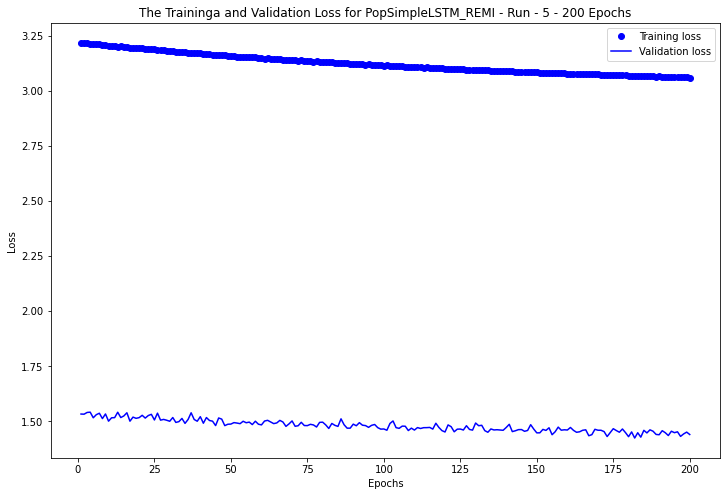

In [ ]:
np.save("PopSimpleLSTM_REMI_run5_trainloss.npy",np.array(train_loss))
!cp PopSimpleLSTM_REMI_run5_trainloss.npy /content/drive/MyDrive/losses
np.save("PopSimpleLSTM_REMI_run5_valloss.npy",np.array(val_loss))
!cp PopSimpleLSTM_REMI_run5_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,run=5,modelname="PopSimpleLSTM_REMI",ylimit=None)

In [ ]:
train_loss, val_loss = train(PopSimpleLSTM_REMI,train_dataloader,val_dataloader,200,200,
      loss_fun,optimizer,'cuda',6,grad_clip=1.0,mname="PopSimpleLSTM_REMI",scheduler=scheduler)

  0%|          | 0/19400 [00:00<?, ?it/s]

EPOCHS : 1/200 Loss : 3.059720
The mean validation loss is 1.458521

Adjusting learning rate of group 0 to 3.3449e-07.
EPOCHS : 2/200 Loss : 3.059901
The mean validation loss is 1.450698

Adjusting learning rate of group 0 to 3.3449e-07.
EPOCHS : 3/200 Loss : 3.058186
The mean validation loss is 1.463949

Adjusting learning rate of group 0 to 3.3449e-07.
EPOCHS : 4/200 Loss : 3.058154
The mean validation loss is 1.449296

Adjusting learning rate of group 0 to 3.3114e-07.
EPOCHS : 5/200 Loss : 3.057618
The mean validation loss is 1.447115

Adjusting learning rate of group 0 to 3.3114e-07.
EPOCHS : 6/200 Loss : 3.057460
The mean validation loss is 1.434144

Adjusting learning rate of group 0 to 3.3114e-07.
EPOCHS : 7/200 Loss : 3.055606
The mean validation loss is 1.442882

Adjusting learning rate of group 0 to 3.3114e-07.
EPOCHS : 8/200 Loss : 3.056035
The mean validation loss is 1.443139

Adjusting learning rate of group 0 to 3.3114e-07.
EPOCHS : 9/200 Loss : 3.056892
The mean validati

In [ ]:
np.save("PopSimpleLSTM_REMI_run6_trainloss.npy",np.array(train_loss))
!cp PopSimpleLSTM_REMI_run6_trainloss.npy /content/drive/MyDrive/losses
np.save("PopSimpleLSTM_REMI_run6_valloss.npy",np.array(val_loss))
!cp PopSimpleLSTM_REMI_run6_valloss.npy /content/drive/MyDrive/losses
plot_loss(train_loss,val_loss,run=6,modelname="PopSimpleLSTM_REMI",ylimit=None)

# Music Generation

In [ ]:
pitch_range = range(21, 109)
beat_res = {(0, 4): 8, (4, 12): 4}
nb_velocities = 32


# get hidden state: extract variable bars of info
def get_hidden(model,name,bar=1,ln=2000):
  # get tokenized remi representation of the music
  tokenizer = REMI(pitch_range,beat_res,nb_velocities) # initialize tokenizer
  folder = "Generated Music/Input/"
  midi = MidiFile(folder+name+".midi")
  events_MIDI = tokenizer.midi_to_tokens(midi)

  # extract events based on number of bars
  count_bars = 0
  start_position = 2 # since the first two events are bars
  events_MIDI = events_MIDI[0]
  position = start_position
  while count_bars < bar: # if the number of bars already satisfies the request, break
    #print(position)
    if events_MIDI[position] == 1:
      # if current position is a bar, then add number of bars counts
      count_bars+=1
    else:
      # if not, move to the next position
      position += 1
    if position + 1 == len(events_MIDI):
      # if already reached the end of events, break
      break
  
  # now from beginning to position will have required number of bars (segment of music)
  input_seq = events_MIDI[:position]

  # fed into model to obtain hidden state
  input_seq = torch.tensor(input_seq,dtype=torch.long)
  model.eval()
  op,hidden = model(input_seq)

  return generate_music(model,hidden,ln)

In [ ]:
def generate_music(model,hidden,ln):
  # initialize
  sequence = [1] # bar event signals starting of a section
  model.eval()
  event = 1

  for i in range(ln+200): # stop at the next bar event after ln
    op, hidden = model(torch.tensor([event],dtype=torch.long),hidden)

    # extract event from output, op is 218 dimension
    _, event = torch.max(op,1)
    event = event.data.squeeze()
    event = event.long()

    # append the new event
    sequence.append(event.detach().numpy().item())

    # if reach ln, and reached at the next bar event, stop
    if len(sequence) >= ln:
      if event == 1:
        return sequence



In [ ]:
output_seq = get_hidden(PopComplexLSTM_REMI.cpu(),"001",4)

In [ ]:
tokenizer = REMI(pitch_range,beat_res,nb_velocities)
folder = "Generated Music/Input/"
midi = MidiFile(folder+"001"+".midi")
output_midi = tokenizer.tokens_to_midi([output_seq],get_midi_programs(midi))

In [ ]:
output_midi.dump("test.midi")